# An Analysis of Wind Speeds in the North Sea

---

### Data

We will be working with [data](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/) collected by [DWD](https://dwd.de) on Helgoland in a 10-minute intervall from 1996 to 2022. For loading the data, we have to manually collect the from a http server.


### Imports and Usage

You can simply use the `environment.yml` file to create a new conda environment with all the needed packages by running `conda env create -f environment.yml`. The only relevant parameter you may want to change is `RELOAD`. If set to `True`, all the needed data will be downloaded and saved in the `data/` folder.

## Data Loading

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl
import requests as rq
import zipfile
from bs4 import BeautifulSoup
import os
import seaborn as sns
import pickle
import datetime as dt
import matplotlib.dates as mdt
from tueplots import bundles
import tueplots as tp
import math
import scipy.optimize as opt
import scipy
import functools

plt.rcParams.update(bundles.beamer_moml())
plt.rcParams['figure.dpi'] = 400
plt.rcParams["font.family"] = "DejaVu Sans"

# set true to download the data and unzip into the current directory
RELOAD = False
ZIP_NAME = "data.zip"
DATA_FOLDER = "data"

DATA_BASE_URL = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/"
KINDS = ["wind", "air_temperature", "precipitation", "solar"]
METRIC_URLS = [DATA_BASE_URL + postfix + "/historical/" for postfix in KINDS]
print(METRIC_URLS)

['https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/wind/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/air_temperature/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/precipitation/historical/', 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/10_minutes/solar/historical/']


In [2]:
def download_and_extract(url: str, kind: str, station_id: str = "02115") -> dict:
    response = rq.get(url)
    soup = BeautifulSoup(response.text, "html.parser")

    # find dataset desciption (pdf)
    descr_resp = rq.get(f"{DATA_BASE_URL}/{kind}")
    descr_soup = BeautifulSoup(descr_resp.text, "html.parser")
    descriptions = [a.get("href") for a in descr_soup.find_all("a", href=True) if a.get("href").__contains__("pdf")]
    descrs_resps = list(map(lambda desc: rq.get(f"{DATA_BASE_URL}/{kind}/{desc}"), descriptions))

    # Extract all links with data of the appropiate station
    links = [a.get("href") for a in soup.find_all('a', href=True) if a.get("href").__contains__(station_id)]
    print(f"Found links: {links}")

    responses = [rq.get(url + file) for file in links]

    # check if we need to create folders
    save_path = os.path.join("data", kind)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # save dataset description pdfs
    for descr, resp in zip(descriptions, descrs_resps):
        with open(os.path.join(save_path, descr), "wb") as file:
            file.write(resp.content)

    # for each matching response download the zip and extract it
    files = [] # remember file names of the extracted zip files
    for i, r in enumerate(responses):
        zip_name = os.path.join("data", kind, f"file{i}.zip")
        with open(zip_name, "wb") as z:
            z.write(r.content)

        with zipfile.ZipFile(zip_name, "r") as zip_file:
            for filename in zip_file.namelist():
                files.append(os.path.join(save_path, filename))
            zip_file.extractall(os.path.join("data", kind))

        # we don't need the zip anymore
        os.remove(zip_name)
    
    return files

# have mapping of metric to relevant files for loading into dataframes later on
kind_files = { kind : [] for kind in KINDS }
kind_file_paths = os.path.join("data", "contents.pickle")
if RELOAD:
    for kind, folder in zip(KINDS, METRIC_URLS):
        print(f"{kind}: {folder}")
        files = download_and_extract(folder, kind)
        kind_files[kind] = files

    with open(os.path.join(kind_file_paths), 'wb') as handle:
        pickle.dump(kind_files, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
else:
    with open(kind_file_paths, 'rb') as handle:
        kind_files = pickle.load(handle)

for kind in KINDS:
    print(f"Files containing {kind} data:\n\t{kind_files[kind]}")

Files containing wind data:
	['data/wind/produkt_zehn_min_ff_19961220_19991231_02115.txt', 'data/wind/produkt_zehn_min_ff_20000101_20091231_02115.txt', 'data/wind/produkt_zehn_min_ff_20100101_20191231_02115.txt', 'data/wind/produkt_zehn_min_ff_20200101_20221231_02115.txt']
Files containing air_temperature data:
	['data/air_temperature/produkt_zehn_min_tu_19961219_19991231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20000101_20091231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20100101_20191231_02115.txt', 'data/air_temperature/produkt_zehn_min_tu_20200101_20221231_02115.txt']
Files containing precipitation data:
	['data/precipitation/produkt_zehn_min_rr_19961219_19991231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20000101_20091231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20100101_20191231_02115.txt', 'data/precipitation/produkt_zehn_min_rr_20200101_20221231_02115.txt']
Files containing solar data:
	['data/solar/produkt_zehn_min_sd_19961219_199912

In [3]:
kind_df = { kind: None for kind in KINDS }
for kind, files in kind_files.items():
    dfs = []
    for file in files:
        df = pd.read_csv(file, sep=";")
        df["MESS_DATUM"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H%M")
        dfs.append(df)
    df = pd.concat(dfs)
    df.sort_values(by="MESS_DATUM", inplace=True)
    df.columns = map(lambda c: c if c == "STATIONS_ID" or c == "MESS_DATUM" else f"{c}_{kind}", df.columns)
    # print(f"{kind}:\n{df.describe()}")
    kind_df[kind] = df

In [4]:
dfs = list(kind_df.values())
df = pd.merge(dfs[0], dfs[1], on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=tuple(list(map(lambda x: "_" + x, kind_df.keys()))[:2]))

# Loop through the remaining DataFrames and merge with the result
for i, df1 in enumerate(dfs[2:]):
    df = pd.merge(df, df1, on=["MESS_DATUM", "STATIONS_ID"], how="inner", suffixes=(None, "_" + list(kind_df.keys())[i+2]))

# Display the result
df

STATIONS_ID          MESS_DATUM    QN_wind  FF_10_wind  DD_10_wind  \
0               2115 1996-12-19 10:40:00          1        15.8          70   
1               2115 1996-12-19 10:50:00          1        16.2          70   
2               2115 1996-12-19 11:00:00          1        16.6          70   
3               2115 1996-12-19 11:10:00          1        16.0          80   
4               2115 1996-12-19 11:20:00          1        16.3          70   
...              ...                 ...        ...         ...         ...   
1348936         2115 2022-12-31 23:10:00          3        13.6         230   
1348937         2115 2022-12-31 23:20:00          3        12.4         230   
1348938         2115 2022-12-31 23:30:00          3        12.6         230   
1348939         2115 2022-12-31 23:40:00          3        12.6         230   
1348940         2115 2022-12-31 23:50:00          3        12.9         230   

        eor_wind  QN_air_temperature  PP_10_air_temperature  \
0            eor                 1.0                 1008.2   
1            eor                 1.0                 1008.1   
2            eor                 1.0                 1008.1   
3            eor                 1.0                 1008.1   
4            eor                 1.0                 1008.0   
...          ...                 ...                    ...   
1348936      eor                 NaN                 1000.6   
1348937      eor                 NaN                 1000.6   
1348938      eor                 NaN                 1000.5   
1348939      eor                 NaN                 1000.6   
1348940      eor                 NaN                 1000.7   

         TT_10_air_temperature  TM5_10_air_temperature  ...  \
0                          2.0                     1.9  ...   
1                          2.0                     1.9  ...   
2                          2.1                     2.1  ...   
3                          2.3                     2.2  ...   
4                          2.1                     2.0  ...   
...                        ...                     ...  ...   
1348936                   11.1                    10.3  ...   
1348937                   10.9                    10.2  ...   
1348938                   11.1                    10.3  ...   
1348939                   11.2                    10.4  ...   
1348940                   11.2                    10.4  ...   

         RWS_IND_10_precipitation    QN_precipitation  eor_precipitation  \
0                               0                 NaN                NaN   
1                               0                 NaN                NaN   
2                               0                 NaN                NaN   
3                               0                 NaN                NaN   
4                               0                 NaN                NaN   
...                           ...                 ...                ...   
1348936                         0                 3.0                eor   
1348937                         0                 3.0                eor   
1348938                         0                 3.0                eor   
1348939                         0                 3.0                eor   
1348940                         0                 3.0                eor   

        QN_solar  DS_10_solar  GS_10_solar  SD_10_solar  LS_10_solar  \
0            1.0       -999.0       -999.0          0.0         -999   
1            1.0       -999.0       -999.0          0.0         -999   
2            1.0       -999.0       -999.0          0.0         -999   
3            1.0       -999.0       -999.0          0.0         -999   
4            1.0       -999.0       -999.0          0.0         -999   
...          ...          ...          ...          ...          ...   
1348936      NaN          0.0          0.0          0.0         -999   
1348937      NaN          0.0          0.0          0.0  

## Explorative Data Analysis

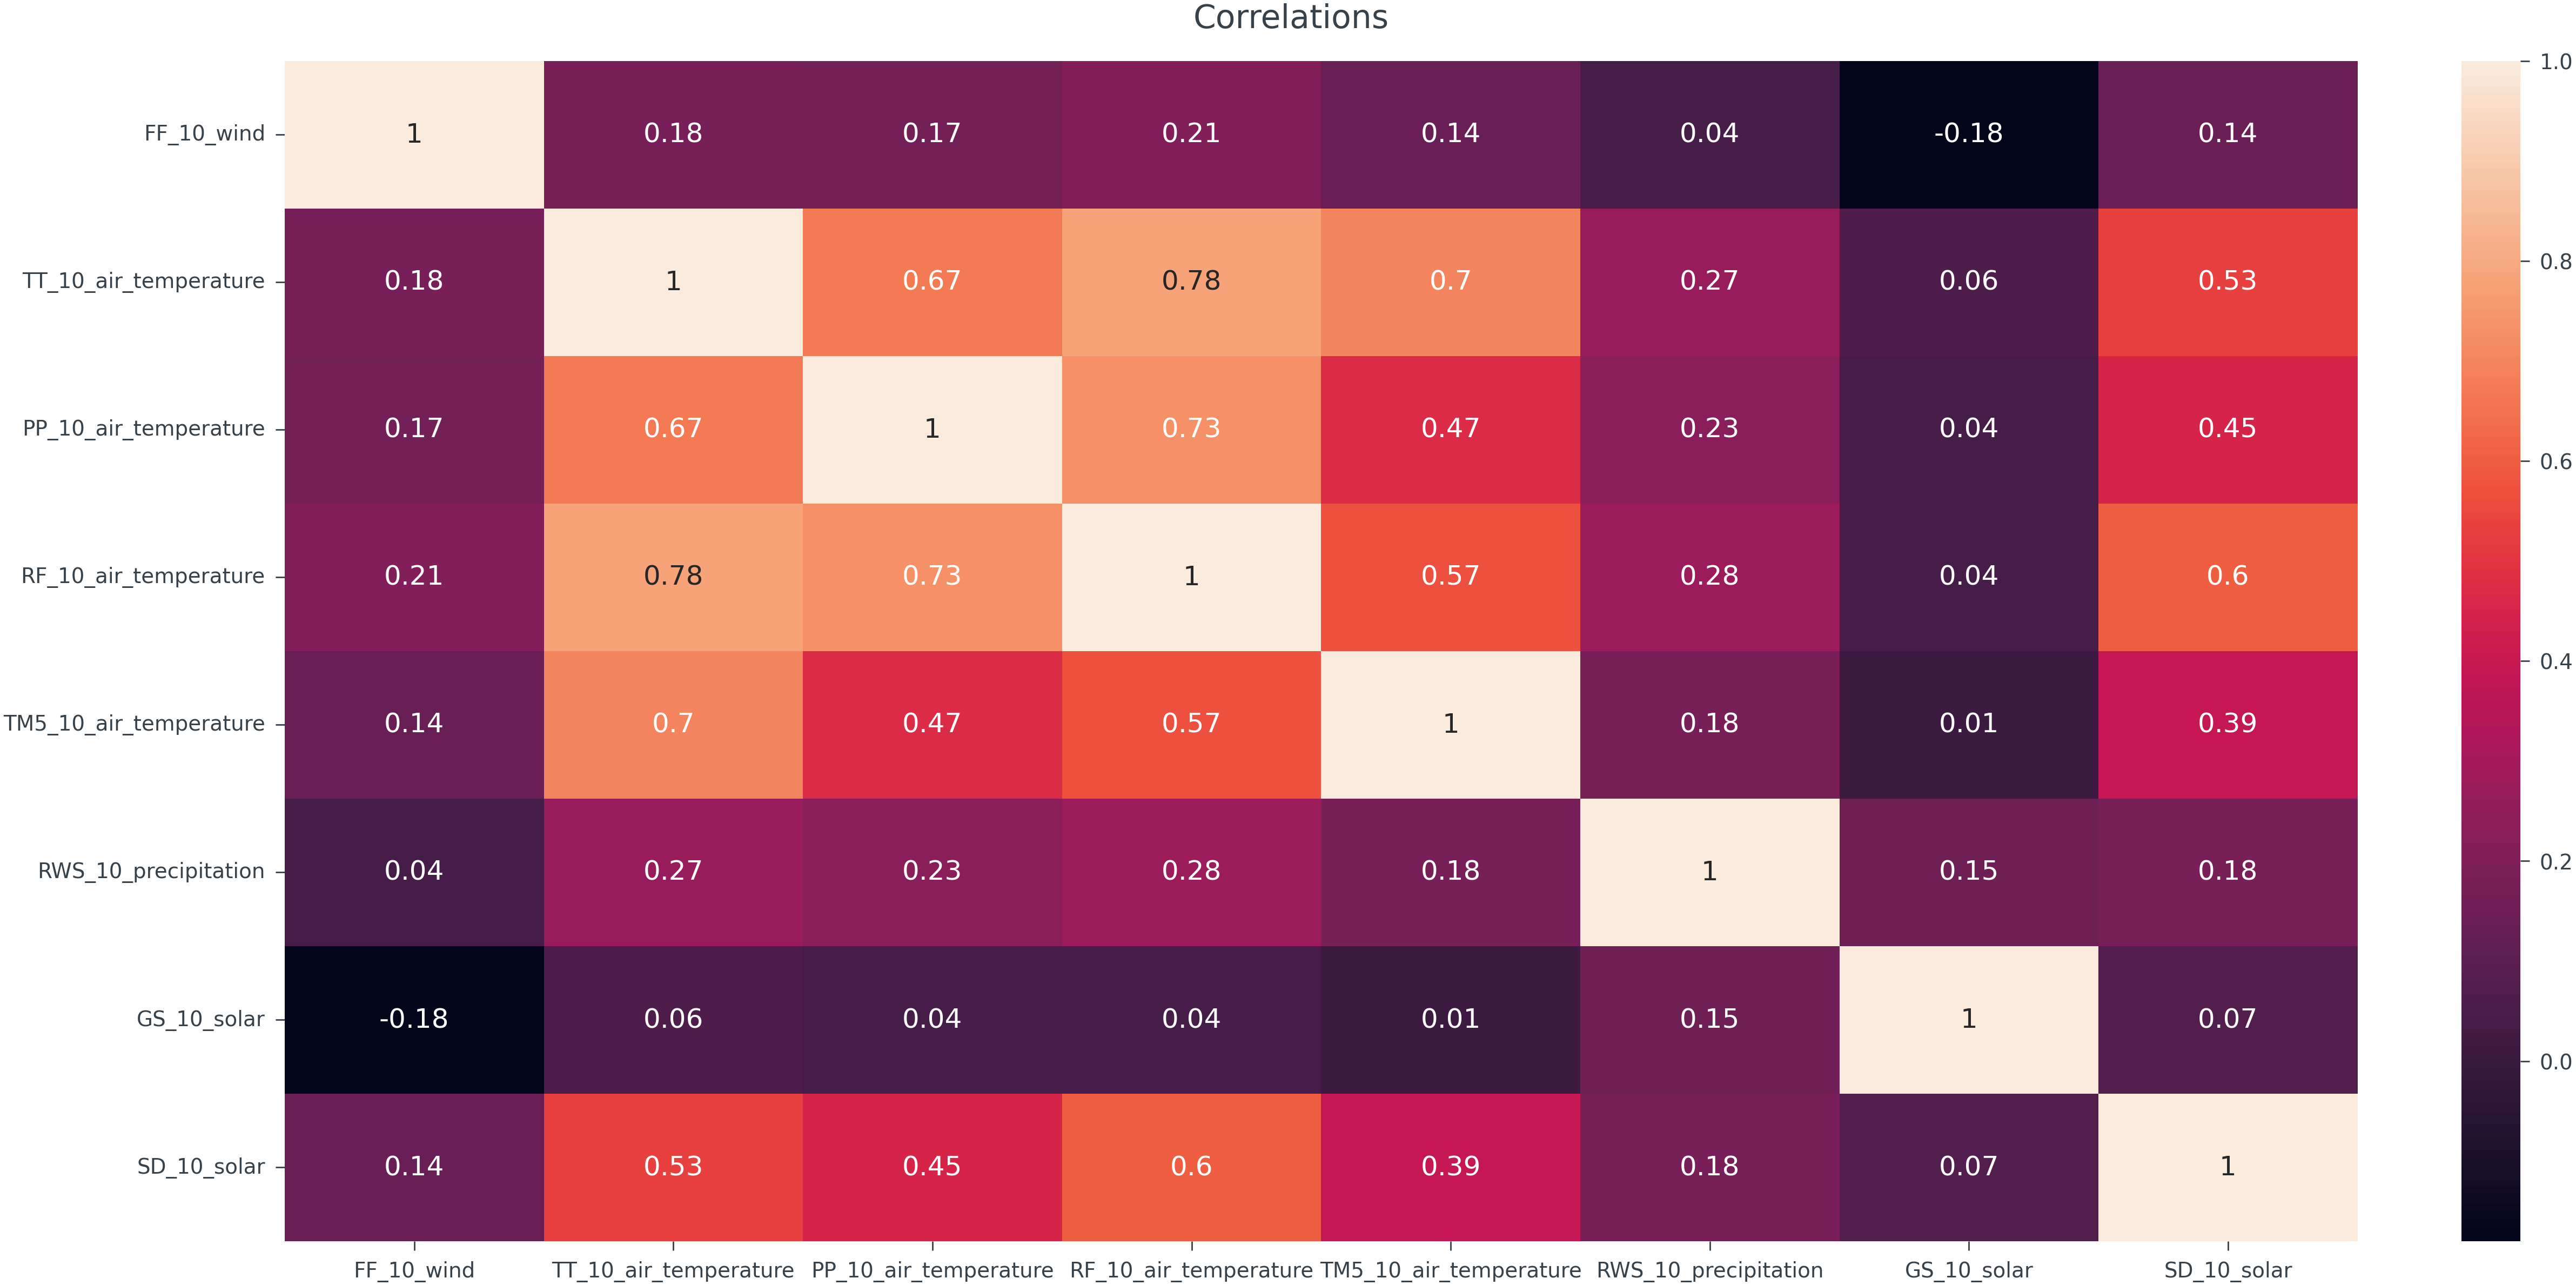

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = df[["FF_10_wind", "TT_10_air_temperature", "PP_10_air_temperature", "RF_10_air_temperature", "TM5_10_air_temperature", "RWS_10_precipitation", "GS_10_solar", "SD_10_solar"]].corr().round(2)
ax = sns.heatmap(corr, annot=True)
fig.suptitle("Correlations")
plt.show()

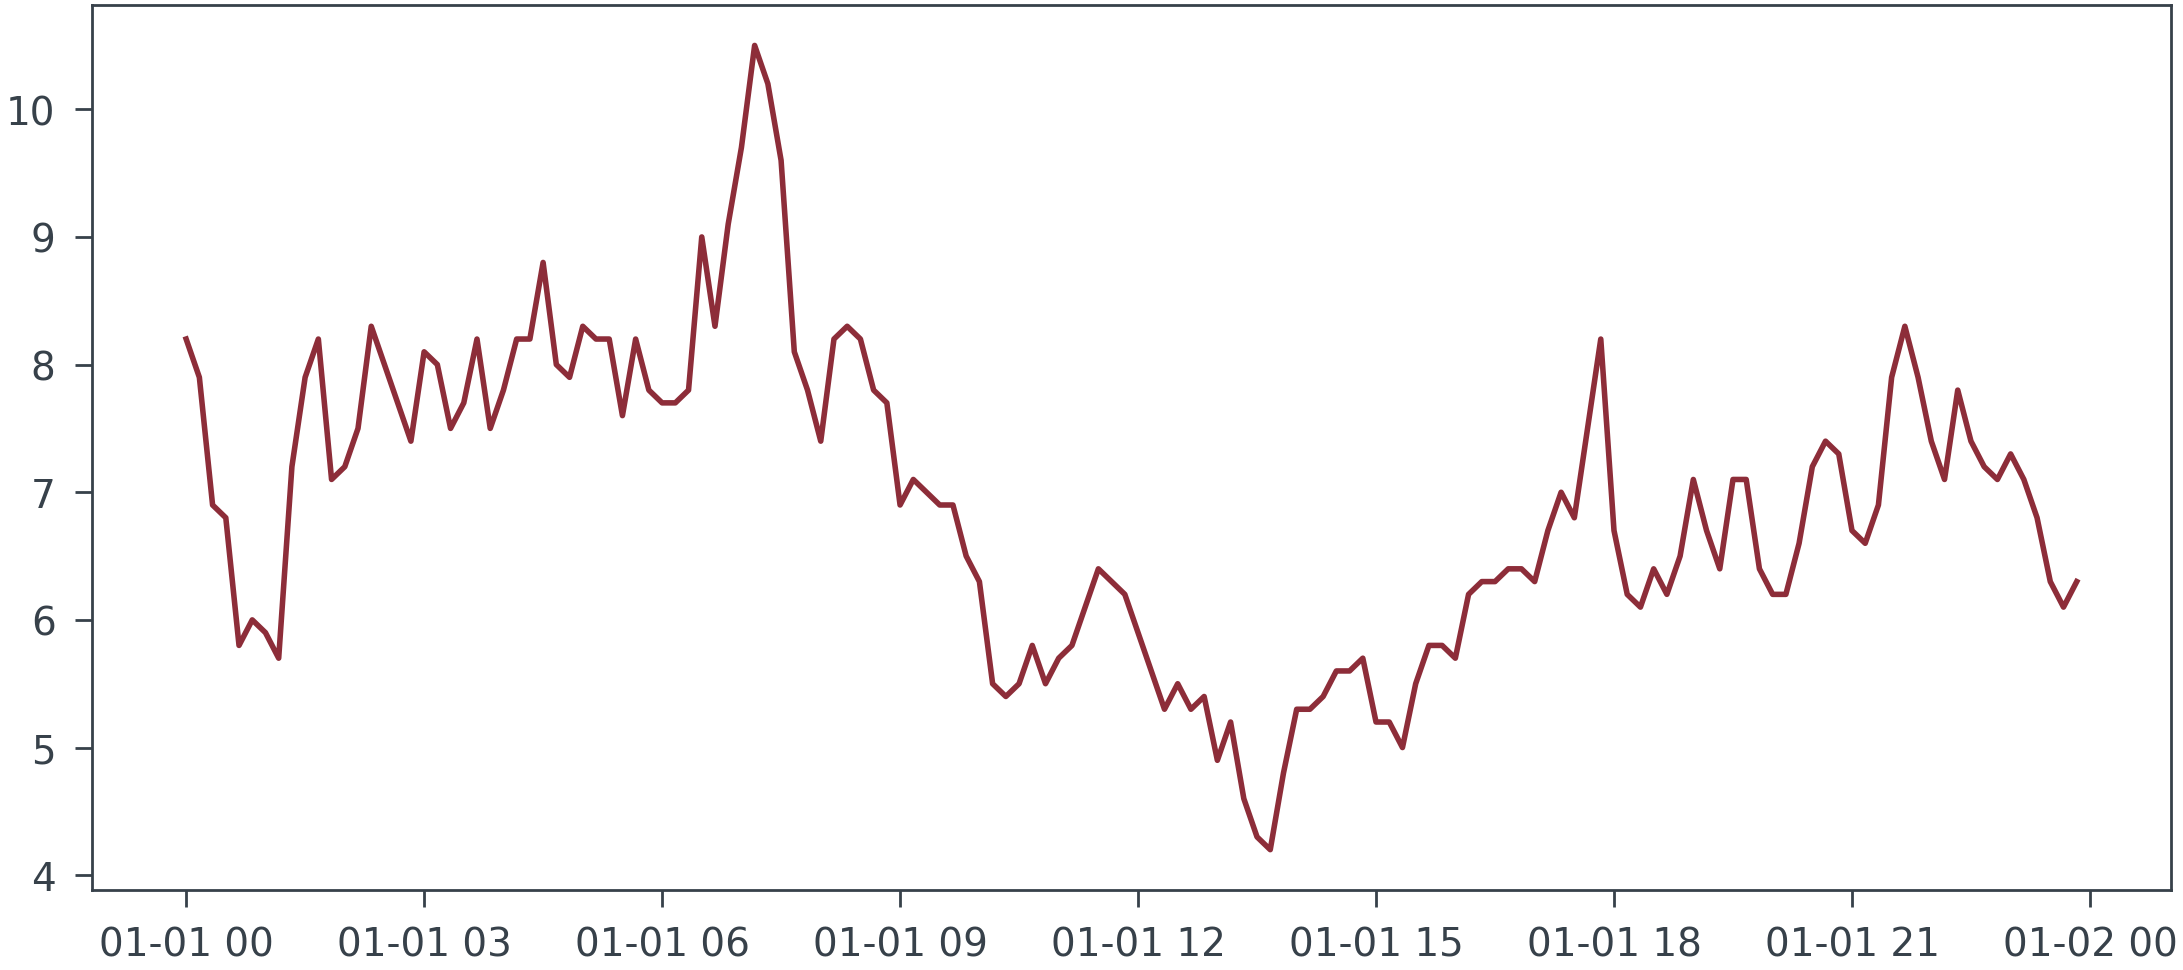

In [6]:
wind_df = kind_df["wind"]
wind_df['FF_10_wind'] = wind_df['FF_10_wind'].replace(-999, float('nan'))
mask = (wind_df['MESS_DATUM'].dt.day == 1) & (wind_df['MESS_DATUM'].dt.month == 1) & (wind_df['MESS_DATUM'].dt.year == 2022)
plt.plot(wind_df[mask]["MESS_DATUM"], wind_df[mask]["FF_10_wind"])


/var/folders/zk/8tsl64_x29qcn5z6qjdgwh5h0000gn/T/ipykernel_16033/1007860517.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


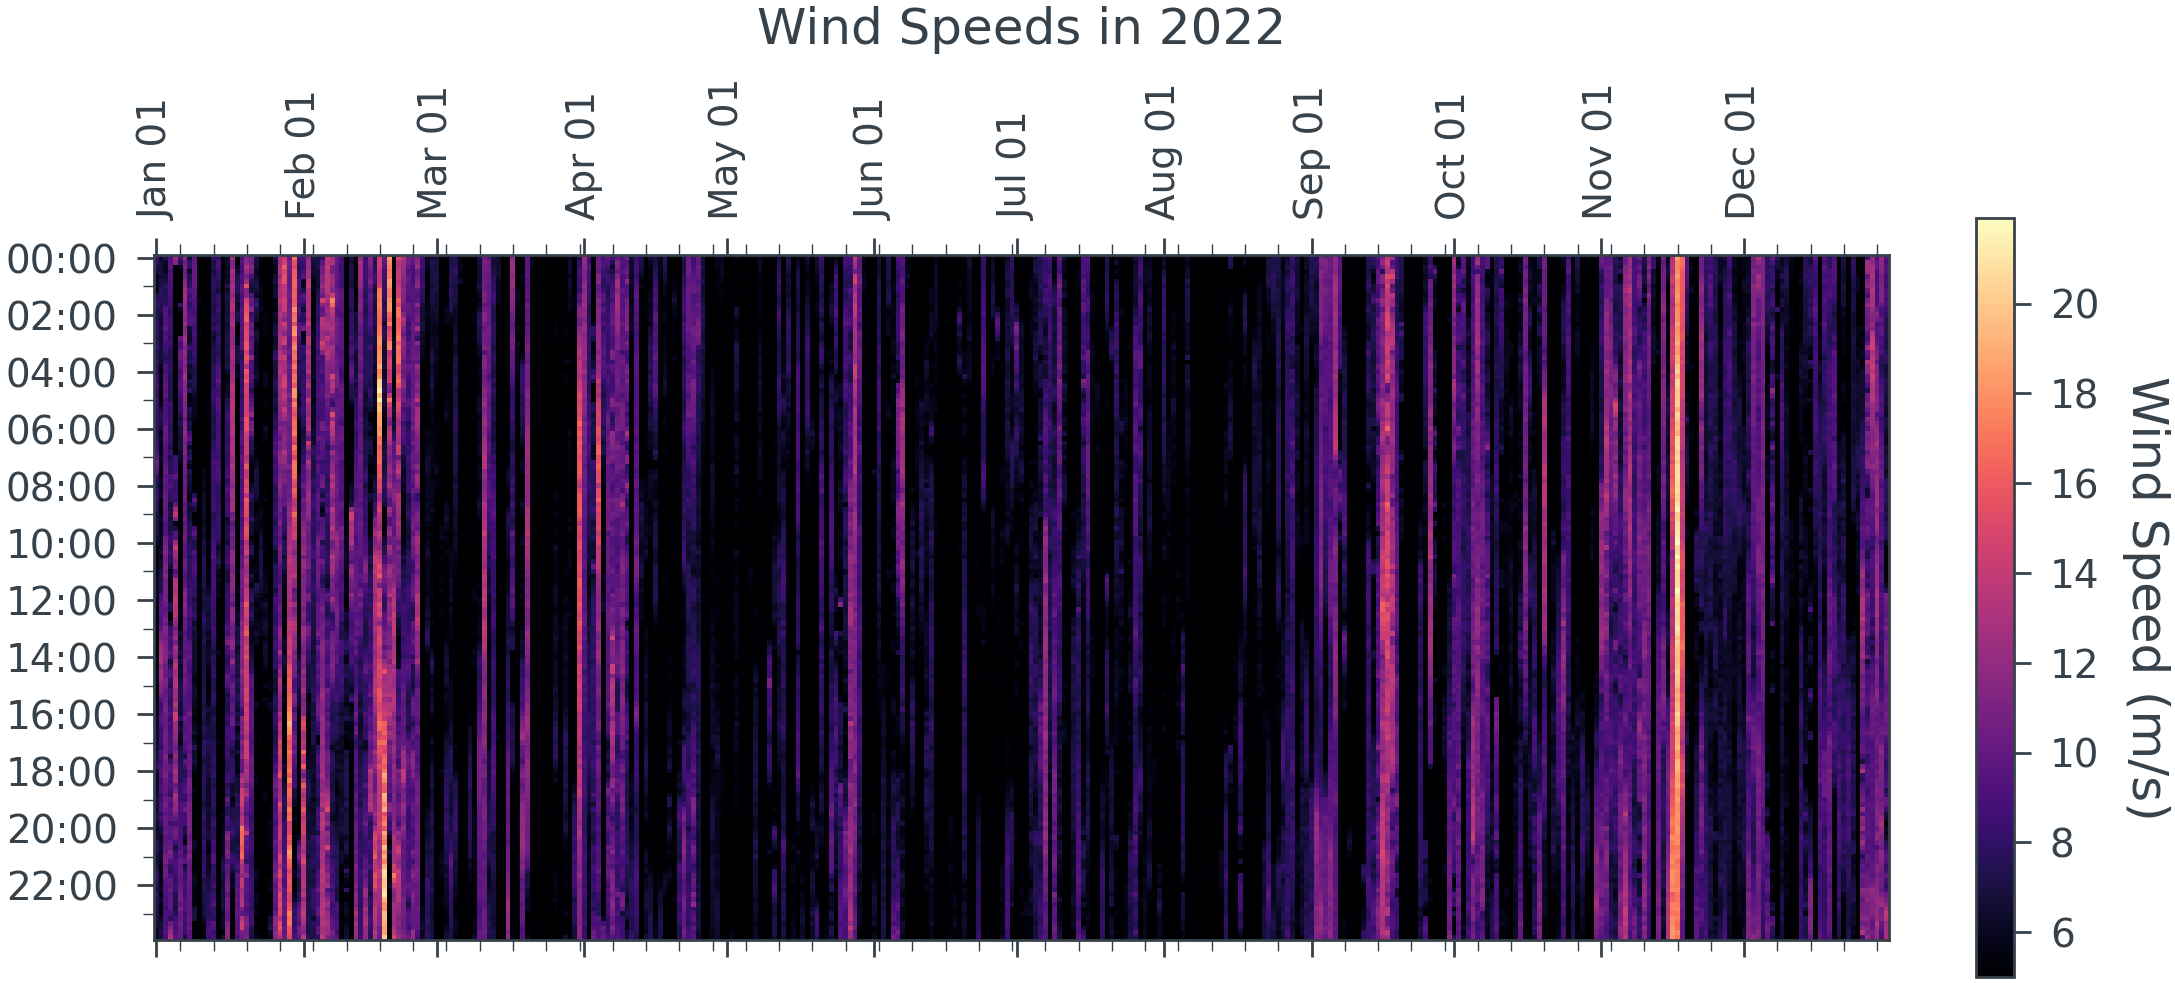

In [7]:
wind_df_2022 = wind_df[wind_df["MESS_DATUM"].dt.year == 2022].copy()
wind_df_2022["Day"] = wind_df_2022["MESS_DATUM"].dt.date
wind_df_2022["Time"] = wind_df_2022["MESS_DATUM"].dt.time

pivot_table_2022 = pd.pivot_table(
    wind_df_2022, values=("FF_10_wind"), index=["Time"], columns=["Day"], aggfunc="mean"
).fillna(0)

fig, ax = plt.subplots()
im = ax.matshow(pivot_table_2022, cmap="magma", vmin=5)

ax.set_yticks(np.arange(len(pivot_table_2022.index))[::12])
ax.set_yticks(np.arange(len(pivot_table_2022))[::6], minor=True)
ax.set_yticklabels([time.strftime("%H:%M") for time in pivot_table_2022.index[::12]])

ax.xaxis.set_major_locator(mdt.MonthLocator(interval=1))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.xaxis.set_minor_locator(
    mdt.WeekdayLocator(interval=1)
)
date_form = mdt.DateFormatter("%b %d")
ax.xaxis.set_major_formatter(date_form)
# ax.grid(which="major", axis="x", linestyle="--", linewidth="0.5", color="gray")
# ax.grid(which="major", axis="y", linestyle="--", linewidth="0.5", color="gray")

cbar = ax.figure.colorbar(im, ax=ax, shrink=1.0)
cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

ax.set_title("Wind Speeds in 2022")
plt.show()

Text(0.5, 0.98, 'Wind Speeds 2015-2022')

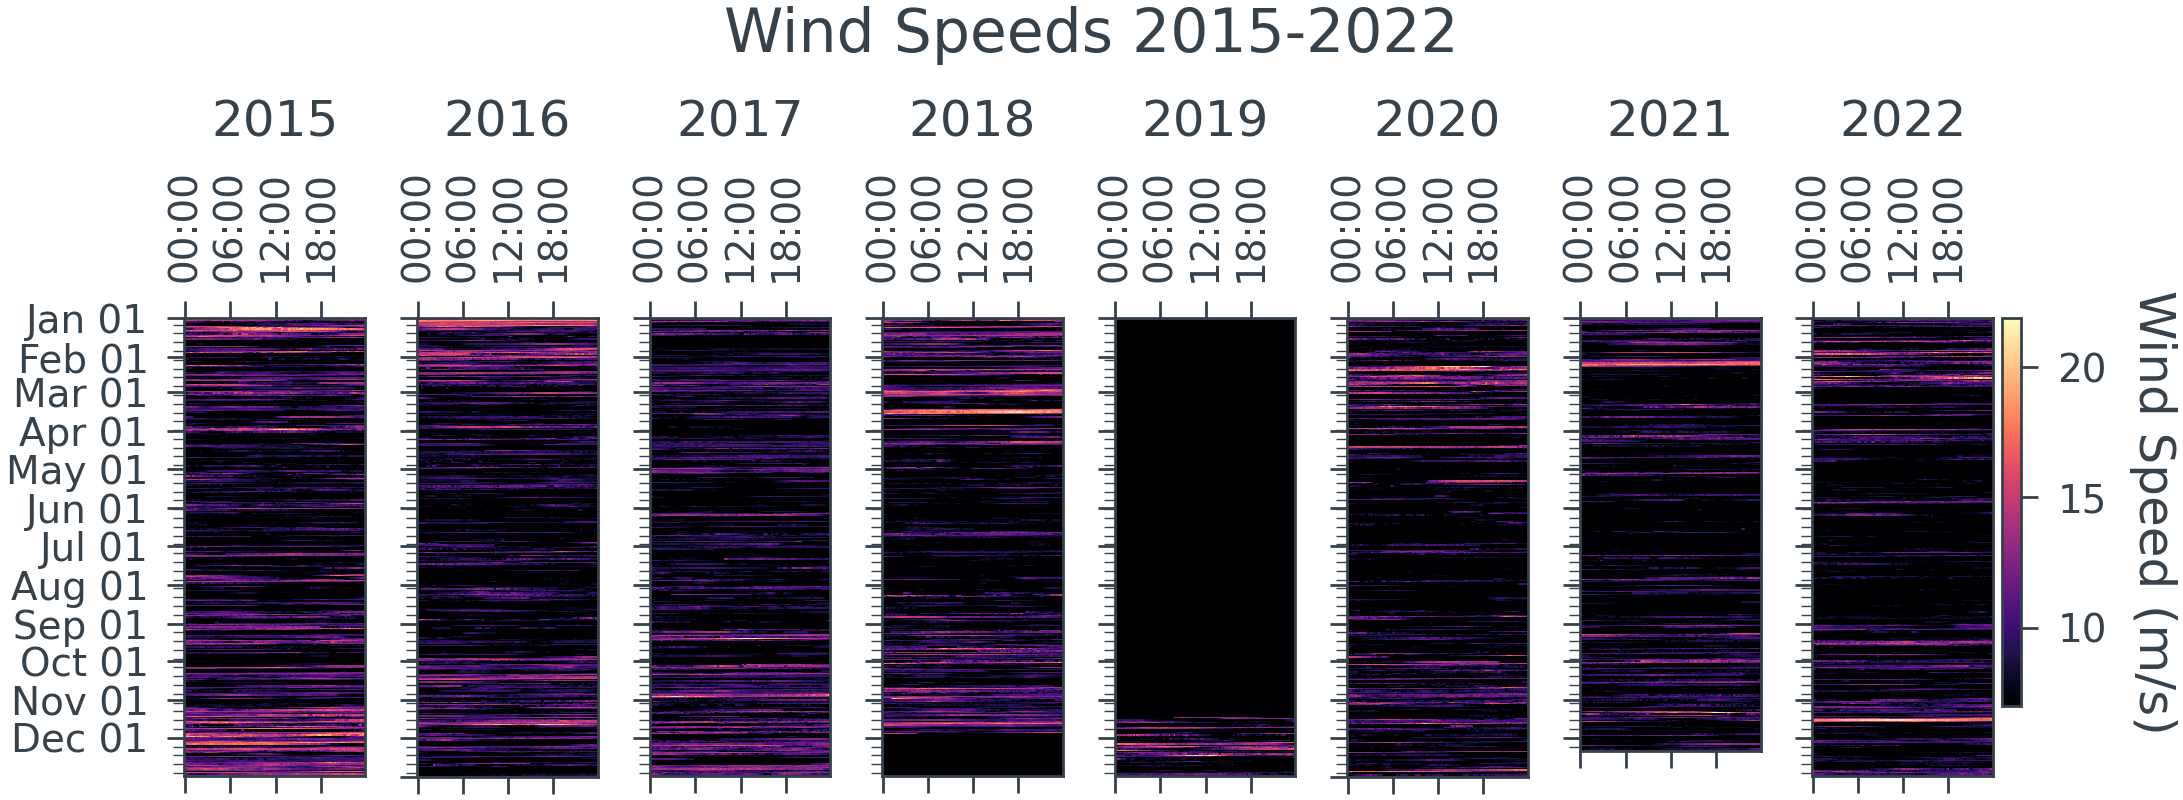

In [8]:
fig, axs = plt.subplots(1, 8, sharex=True, sharey=False)
# fig.suptitle("Wind Speeds in the years 2015-2022")

for i, year in enumerate(range(2015, 2023)):
    ax = axs[i]
    # ax.set_anchor("N")
    mask = wind_df["MESS_DATUM"].dt.year == year
    wind_df_year = wind_df[mask].copy()
    wind_df_year.fillna(0, inplace=True)

    wind_df_year["Day"] = wind_df_year["MESS_DATUM"].dt.date
    wind_df_year["Time"] = wind_df_year["MESS_DATUM"].dt.time

    pivot_table = pd.pivot_table(
        wind_df_year, values=("FF_10_wind"), index=["Day"], columns=["Time"], aggfunc="mean", fill_value=0
    )

    Daystrings = [date.strftime("%d %b") for date in pivot_table.index.values]
    TimeStrings = [time.strftime("%H:%M") for time in pivot_table.columns]

    im = ax.matshow(pivot_table, cmap="magma", vmin=7)

    ax.set_xticks(np.arange(len(pivot_table.columns))[:: (6 * 6)])
    ax.set_xticklabels(TimeStrings[:: (6 * 6)], rotation=90)
    ax.yaxis.set_major_locator(
        mdt.MonthLocator(interval=1)
    )
    ax.yaxis.set_minor_locator(
        mdt.WeekdayLocator(interval=1)
    )
    if i == 0:
        ax.yaxis.set_major_formatter(date_form)
    else:
        ax.set_yticklabels([])

    if i == 7:
        cbar = fig.colorbar(im, ax=ax, shrink=0.6, location="right", anchor=(0.0, 1.0))
        cbar.ax.set_ylabel("Wind Speed (m/s)", rotation=-90, va="bottom")

    ax.set_title(year)

for ax in axs:
    ax.set_anchor("N")
fig.suptitle("Wind Speeds 2015-2022")

In [9]:
# from sklearn.gaussian_process import GaussianProcessRegressor as GP
# import sklearn.gaussian_process.kernels as GPK

# # plt.plot(wind_df_2022["MESS_DATUM"], wind_df_2022["FF_10_wind"])

# kernel = GPK.ExpSineSquared(length_scale=60 * 60, periodicity= 60 * 60 * 12)
# gp = GP(kernel=kernel, optimizer=None)

# start = pd.Timestamp("01-01-2022")
# day_df = wind_df_2022[(wind_df_2022["MESS_DATUM"].dt.day == 1) & (wind_df_2022["MESS_DATUM"].dt.month == 1)].copy().dropna()
# day_df["Duration"] = day_df["MESS_DATUM"] - start
# X = day_df["Duration"].dt.total_seconds().values.reshape(-1, 1)
# plt.plot(X, gp.sample_y(X, 3))
# plt.plot(X, day_df["FF_10_wind"])

# # X_out = np.vstack((X, np.linspace(85800, 85800 + 600 * 100).reshape(-1, 1)))
# X_out = np.array(range(0, 24 * 60 * 60 * 2, 240)).reshape(-1, 1)
# Y = day_df["FF_10_wind"]
# Y_mean = Y.mean()
# print(X_out.shape)
# gp.fit(X, day_df["FF_10_wind"].values.reshape(-1, 1) - day_df["FF_10_wind"].mean())
# pred, std = gp.predict(X_out, return_std=True)
# pred += Y.mean()
# plt.plot(X_out, pred)
# plt.plot(X_out, pred + std, linestyle=":", color="red", alpha=0.5)
# plt.plot(X_out, pred - std, linestyle=":", color="red", alpha=0.5)

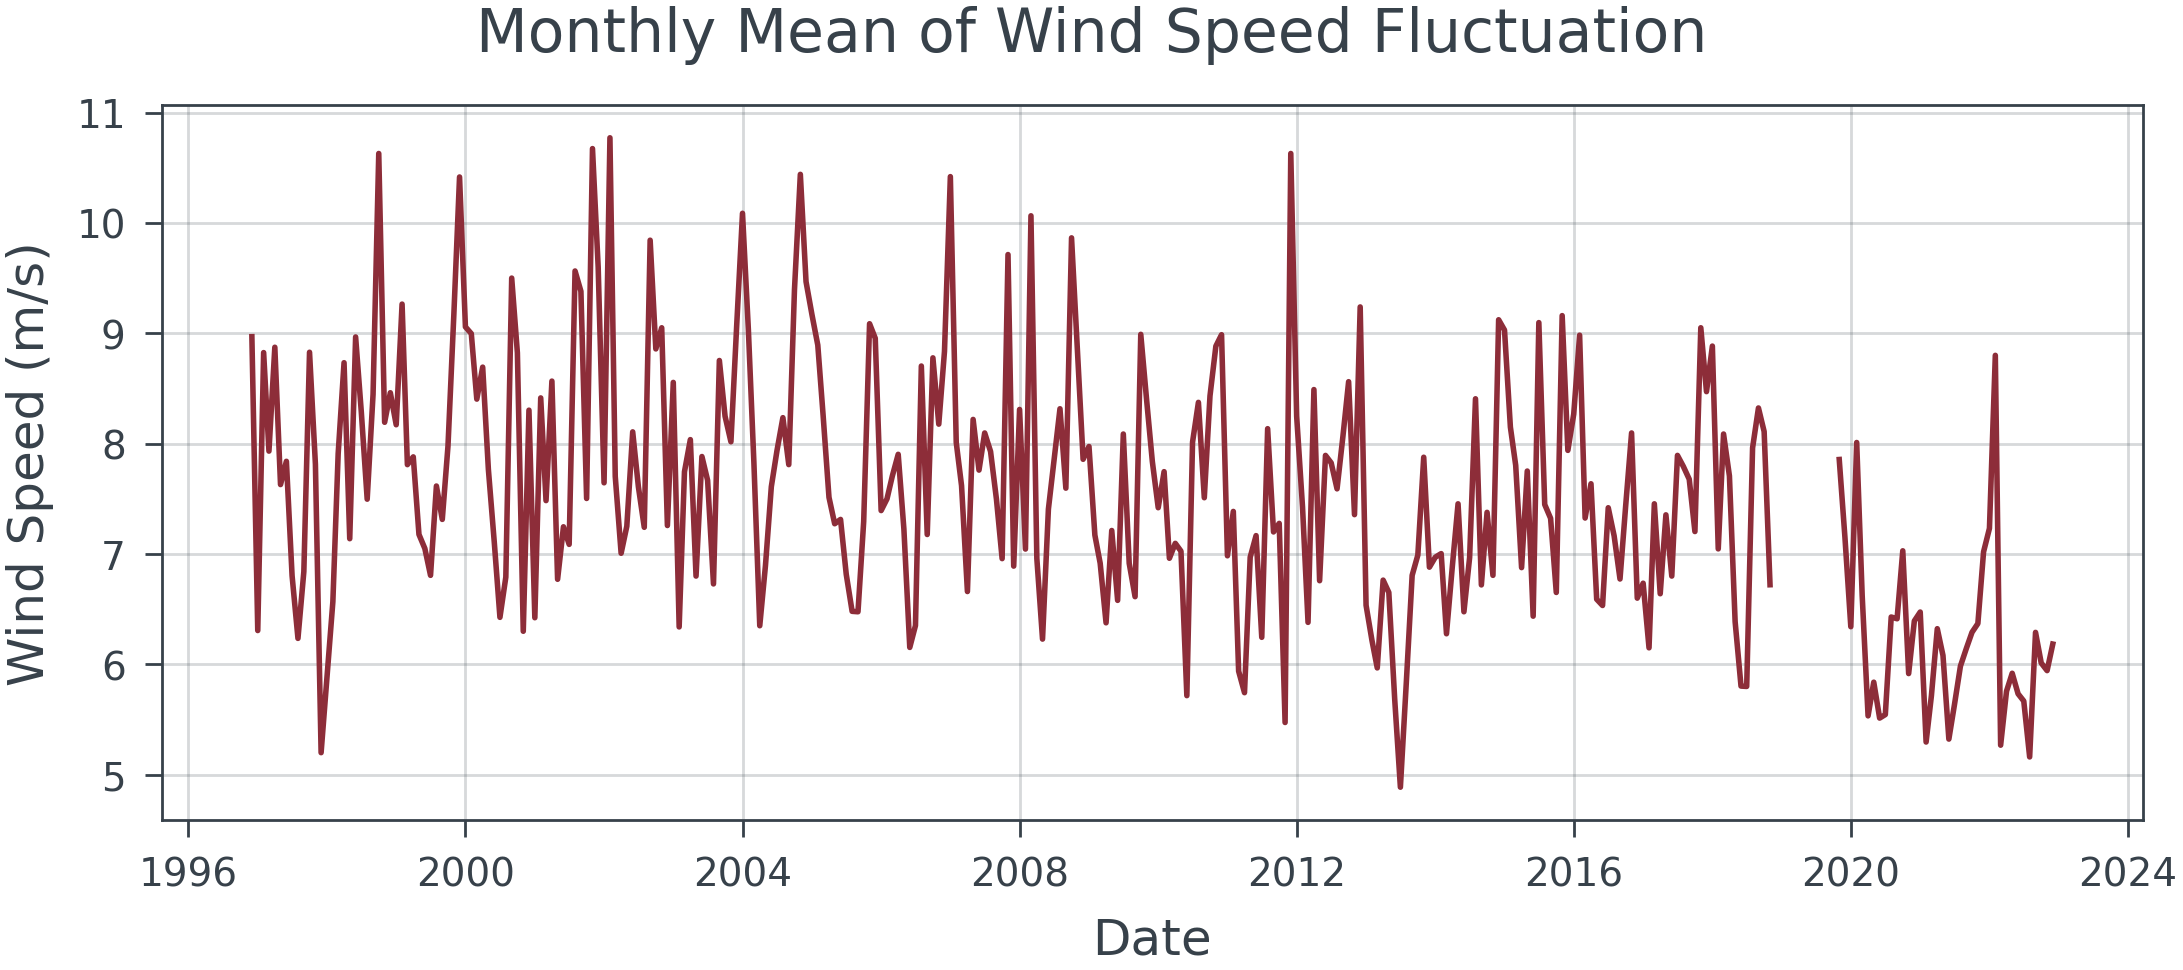

In [10]:
wind_df["year"] = wind_df["MESS_DATUM"].dt.year
wind_df["day"] = wind_df["MESS_DATUM"].dt.day
wind_df["month"] = wind_df["MESS_DATUM"].dt.month
wind_df_by_year = wind_df.groupby(["year", "month", "day"])
wind_df_agg_yr = wind_df_by_year["FF_10_wind"].aggregate(["max", "min"])
wind_df_agg_yr["diff"] = wind_df_agg_yr["max"] - wind_df_agg_yr["min"]
wind_df_agg_yr.reset_index(inplace=True)
wind_df_agg_yr["date"] = pd.to_datetime(wind_df_agg_yr[["year", "month", "day"]])

wind_df_mean_diff = wind_df_agg_yr.groupby(["year", "month"])["diff"].mean().reset_index()
wind_df_mean_diff["date"] = pd.to_datetime(wind_df_mean_diff[["year", "month"]].assign(day=1))

fig, ax = plt.subplots(1, 1)
fig.suptitle("Monthly Mean of Wind Speed Fluctuation")
ax.plot(wind_df_mean_diff["date"], wind_df_mean_diff["diff"])
ax.set_ylabel("Wind Speed (m/s)")
ax.set_xlabel("Date")
ax.grid(which="major")

Text(0.5, 0.98, 'Monthly Mean of Wind Speed Fluctuations')

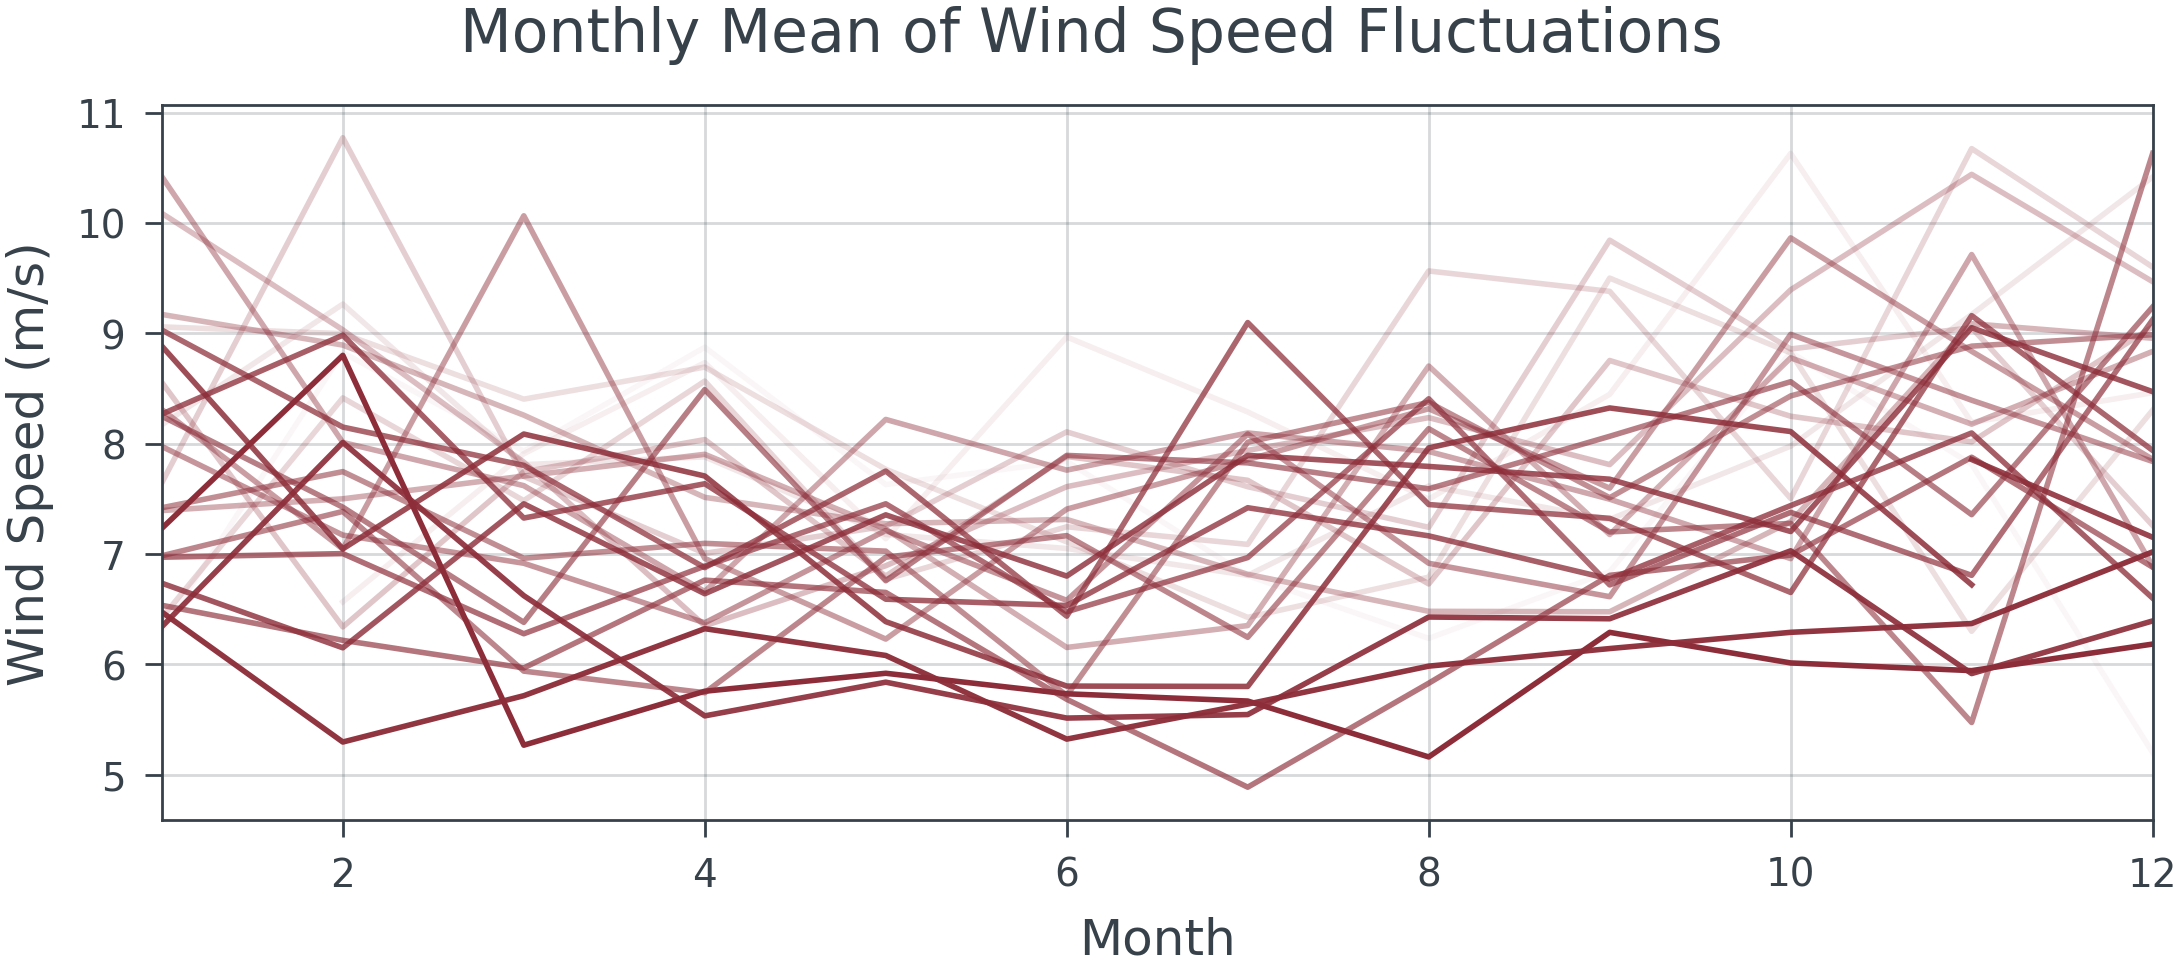

In [11]:
fig, axs = plt.subplots(1, 1)

for year, year_month_df in wind_df_mean_diff.groupby("year"):
    alpha = (year - 1996) / (2022 - 1996)
    axs.plot(year_month_df["month"], year_month_df["diff"], color=tp.constants.color.rgb.tue_red, alpha=alpha)
# sns.boxplot(data=wind_df_agg_yr, x=wind_df_agg_yr.index.values, y="diff")

axs.set_ylabel("Wind Speed (m/s)")
axs.set_xlabel("Month")
axs.set_xlim((1, 12))
axs.grid(which="major")
fig.suptitle("Monthly Mean of Wind Speed Fluctuations")
# wind_df_mean_diff.groupby("year")["diff"].plot(kind="kde", ax=axs[1])

Text(0.5, 0, 'Wind Speeds (m/s)')

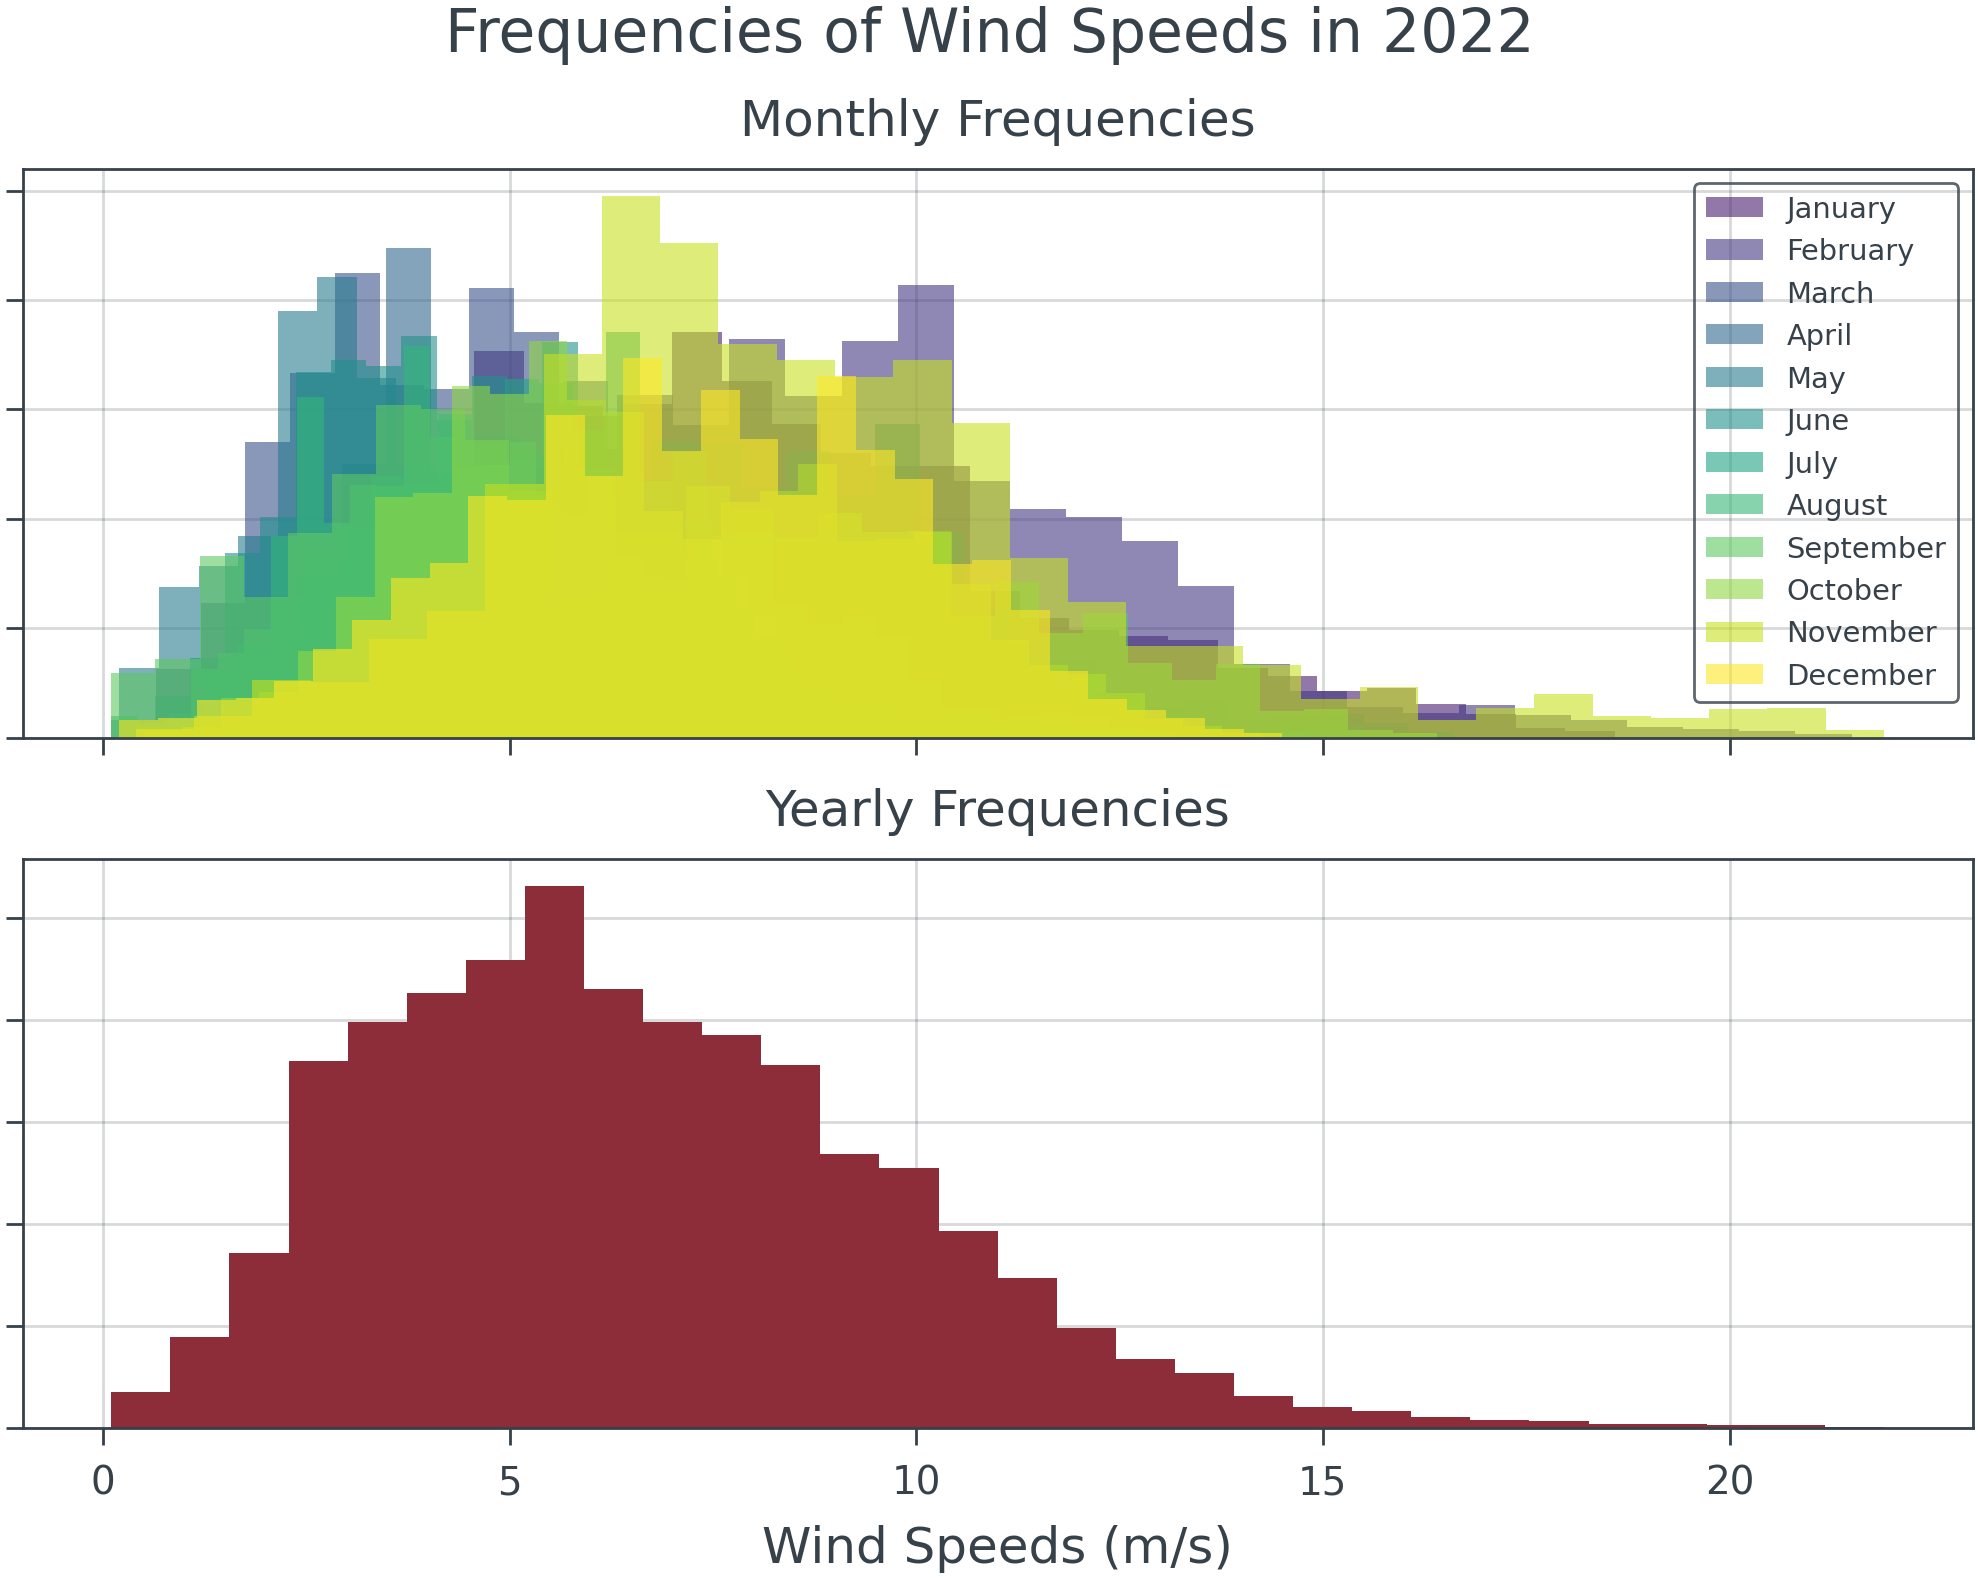

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 4))
# Create a list of colors for the colormap (here, we use a smooth transition from blue to red to blue)
colors = plt.cm.viridis(np.linspace(0, 1, 13))

fig.suptitle("Frequencies of Wind Speeds in 2022")
wind_df_2022["month"] = wind_df_2022["MESS_DATUM"].dt.month
for year, year_month_df in wind_df_2022.groupby("month"):
    year_month_df.hist(column="FF_10_wind", bins=30, ax=ax1, alpha=0.6, label=dt.datetime(2022, year, 1).strftime("%B"), color=colors[year])
# wind_df_2022[wind_df_2022["MESS_DATUM"].dt.month == 6].hist(column="FF_10_wind", bins=20, ax=ax)
ax1.set_title("")
ax1.set_yticklabels([])
# ax1.set_xlabel("Wind Speed (m/s)")
ax1.set_title("Monthly Frequencies")
ax1.legend(loc="upper right", fontsize="xx-small")

wind_df_2022.hist(column="FF_10_wind", bins=30, ax=ax2)
ax2.set_title("Yearly Frequencies")
ax2.set_yticklabels([])
ax2.set_xlabel("Wind Speeds (m/s)")

In [13]:
class Weibull:
    def __init__(self, lambd: float, beta: float):
        self.lambd = lambd
        self.beta = beta

    def pdf(self, X: np.ndarray):
        """
        The probability density function of the Weibull distribution.
        """
        result = np.zeros_like(X)
        non_negative_indices = X > 0
        non_negatives = X[non_negative_indices]
        result[non_negative_indices] = self.beta / self.lambd * (non_negatives / self.lambd) ** (self.beta - 1) * np.exp(- (non_negatives / self.lambd) ** self.beta)
        return result

    def cdf(self, X: np.ndarray):
        """
        The cummulative probability density function of the Weibull distribution.
        """
        result = np.zeros_like(X)
        non_negative_indices = X > 0
        non_negatives = X[non_negative_indices]
        result[non_negative_indices] = 1 - np.exp(- (non_negatives / self.lambd)) ** self.beta
        return result
    
    def expectation(self, X):
        pass
    
    @functools.cached_property
    def mean(self) -> float:
        return self.lambd * scipy.special.gamma(1 + 1 / self.beta)

    @functools.cached_property
    def mode(self) -> float:
        return self.lambd * math.log(2) ** (1 / self.beta)

    def ml_lambda(X: np.ndarray, beta: float) -> float:
        """
        Compute the scale parameter lambda using the maximum likelihood method given a fixed beta.
        """
        N = X.shape[0]
        return (1 / N * np.sum(X ** beta)) ** (1 / beta)

    def ml_beta(X: np.ndarray) -> float:
        """
        Compute the shape parameter beta using the maximum likelihood method.
        """
        N = X.shape[0]
        l_fn = lambda beta: - 1 / N * np.sum(np.log(X)) - 1 / beta + np.sum(X ** beta * np.log(X)) / np.sum(X ** beta)
        return opt.root(l_fn, 2.0)

    def estimate(X: np.ndarray):
        """
        Estimate the parameters of the Weibull distribution using the Maximum Likelihood Method.
        """
        X[X <= 0] = 1e-3
        b = Weibull.ml_beta(X).x
        l = Weibull.ml_lambda(X, b)
        return Weibull(l, b)

findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Roboto Condensed


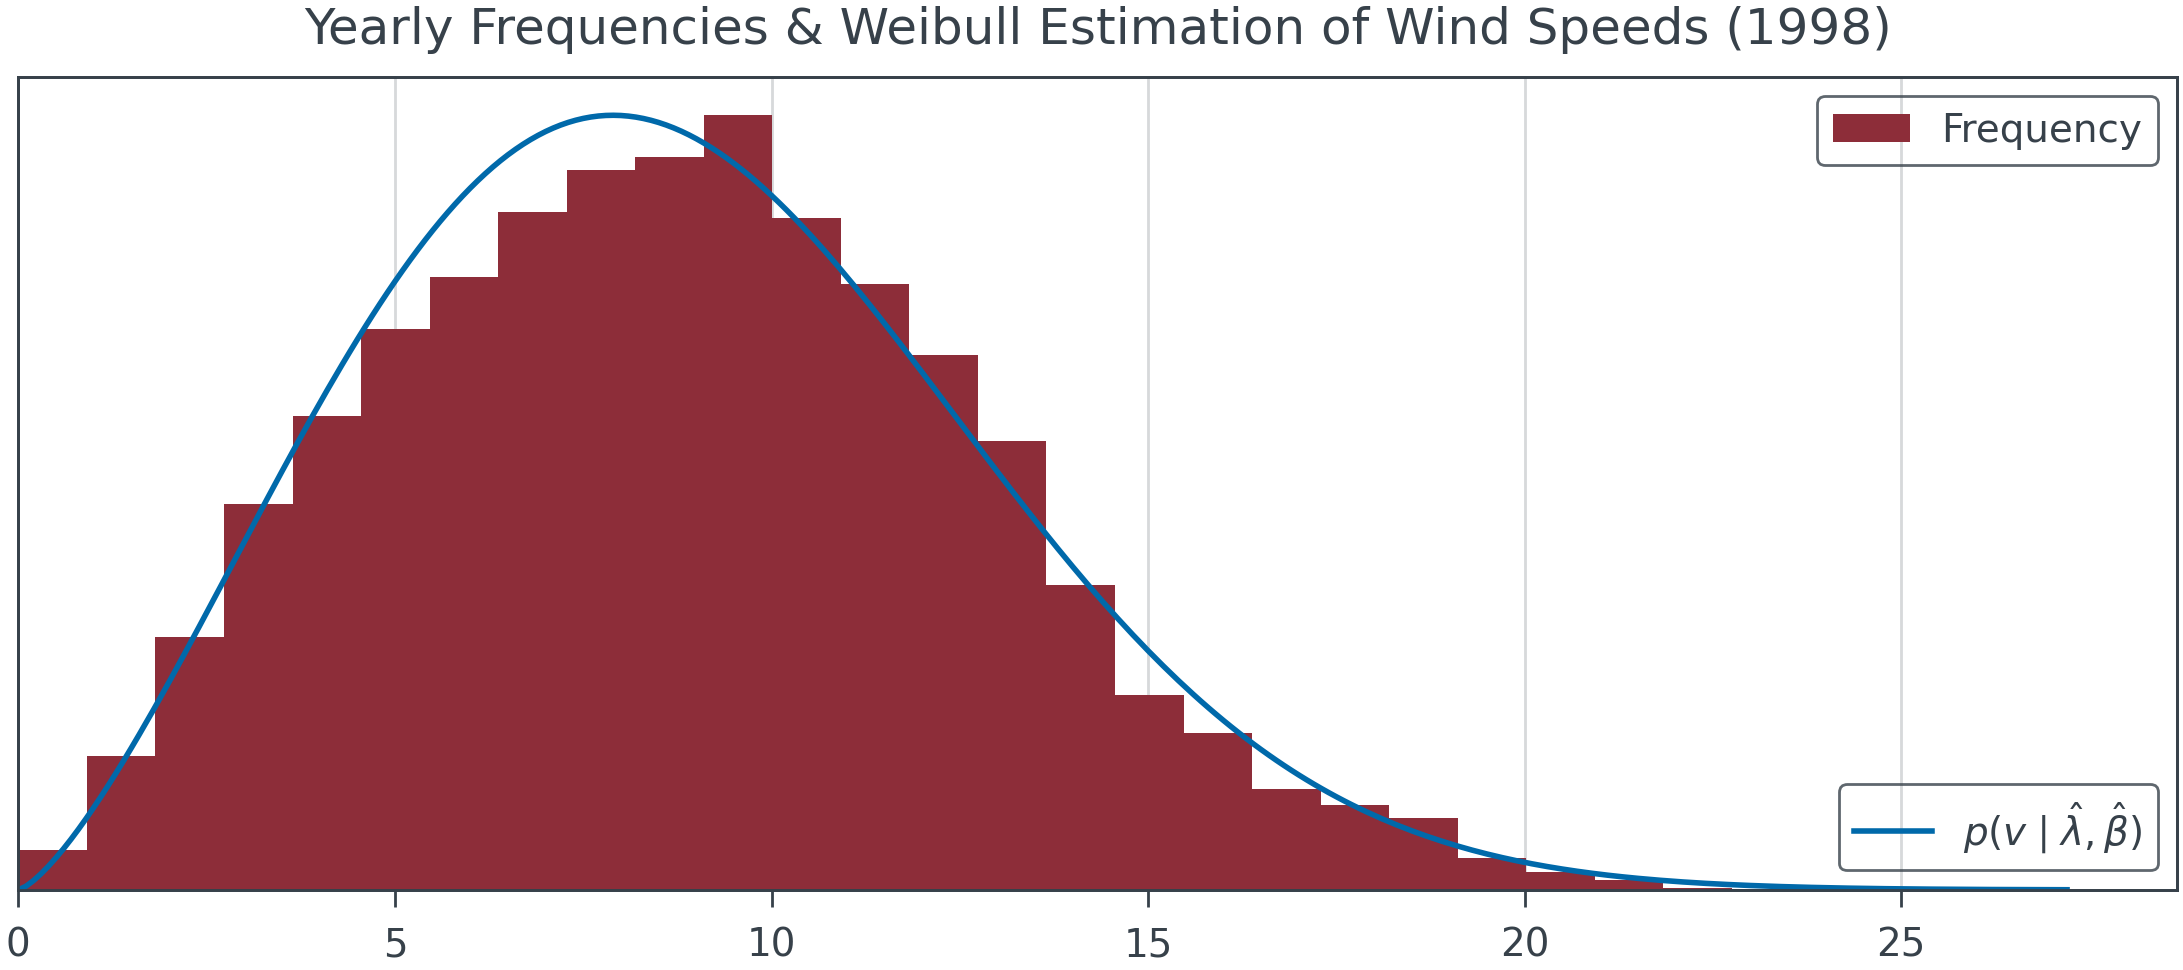

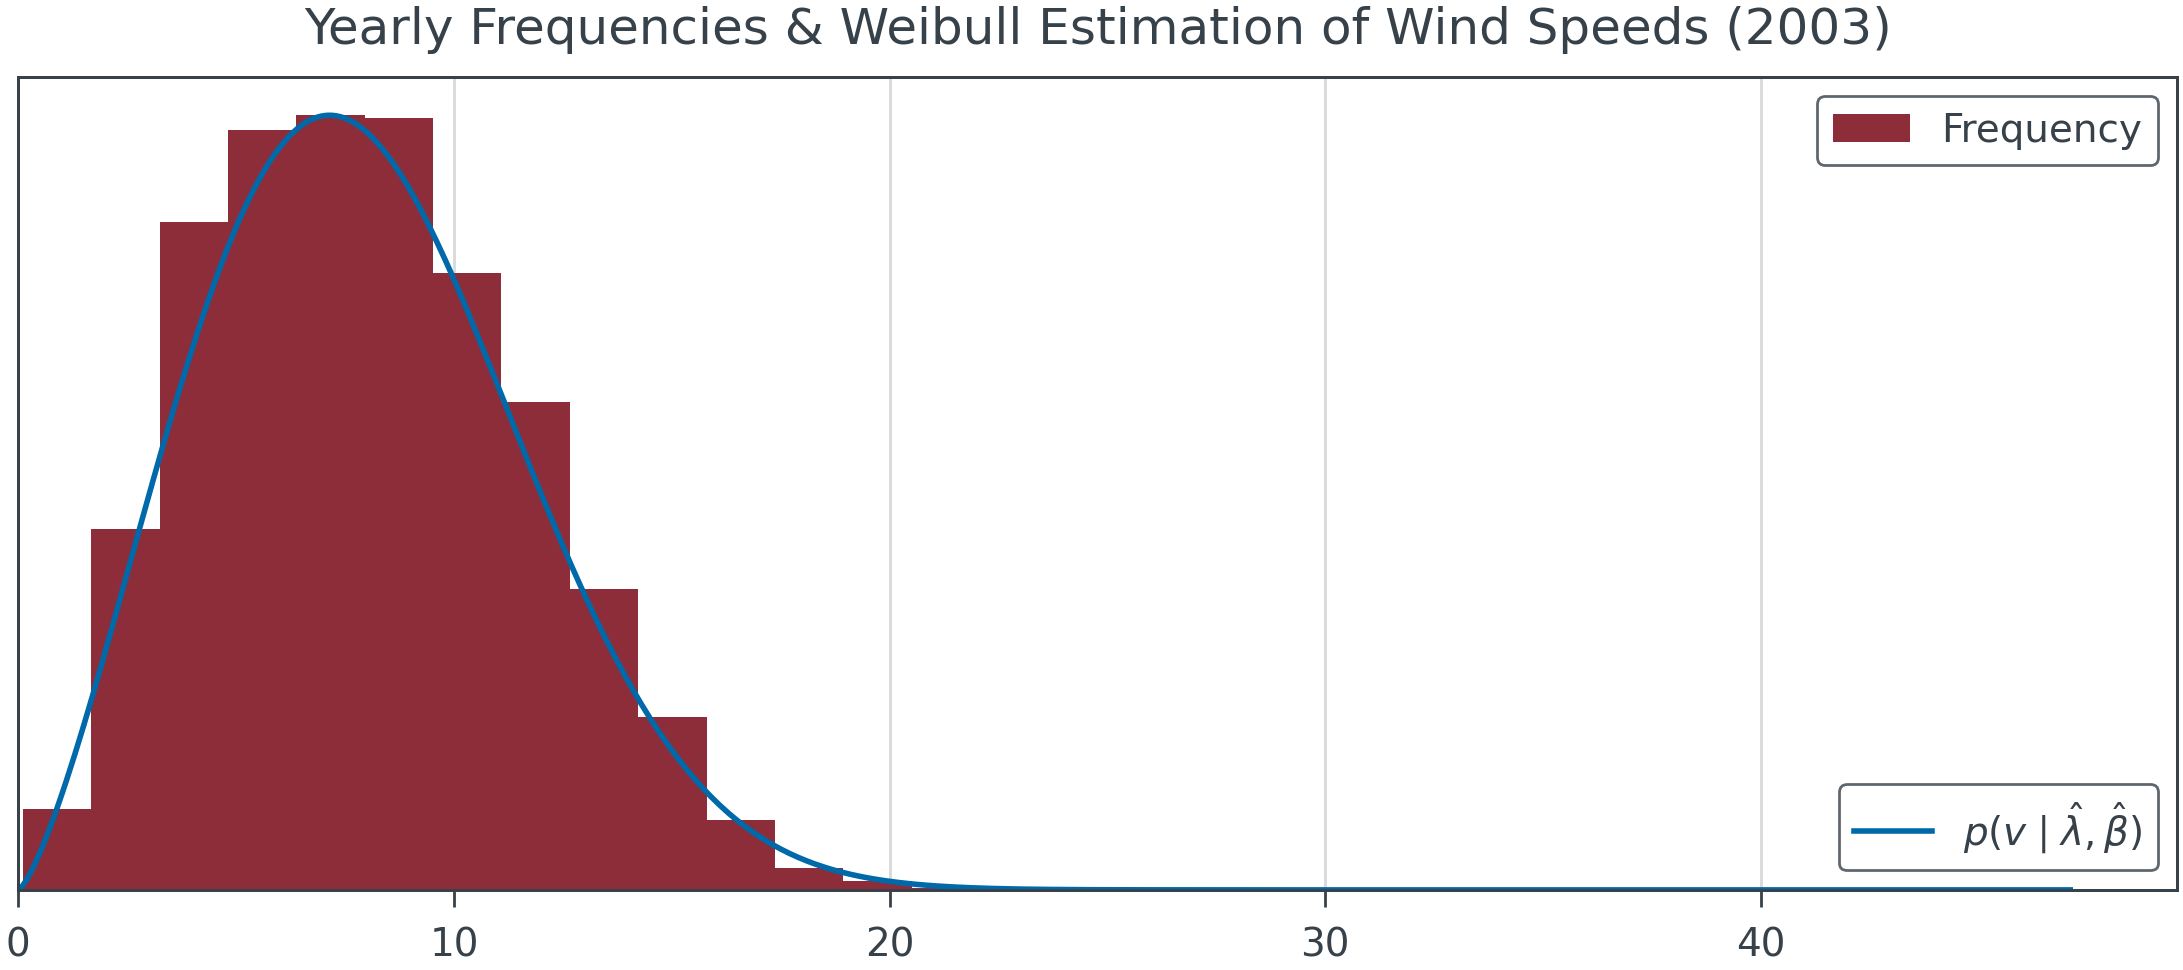

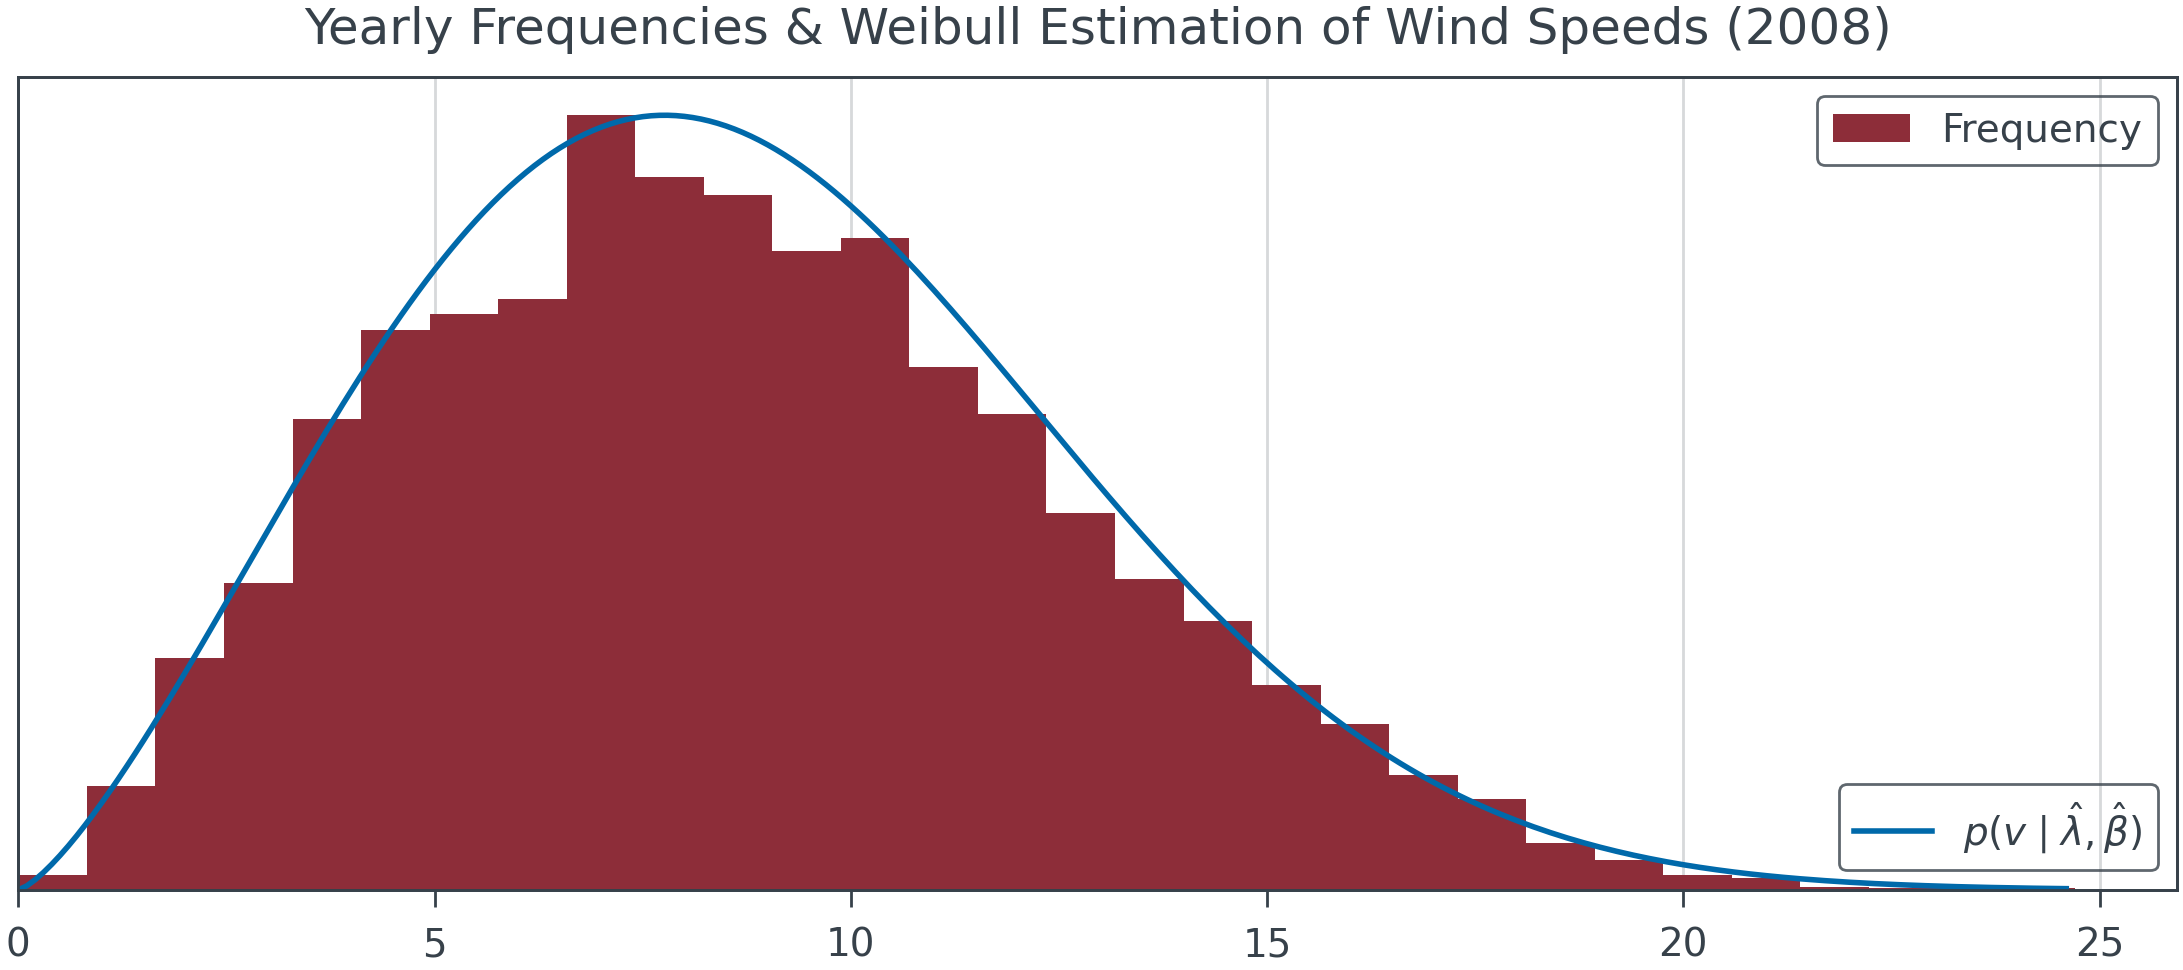

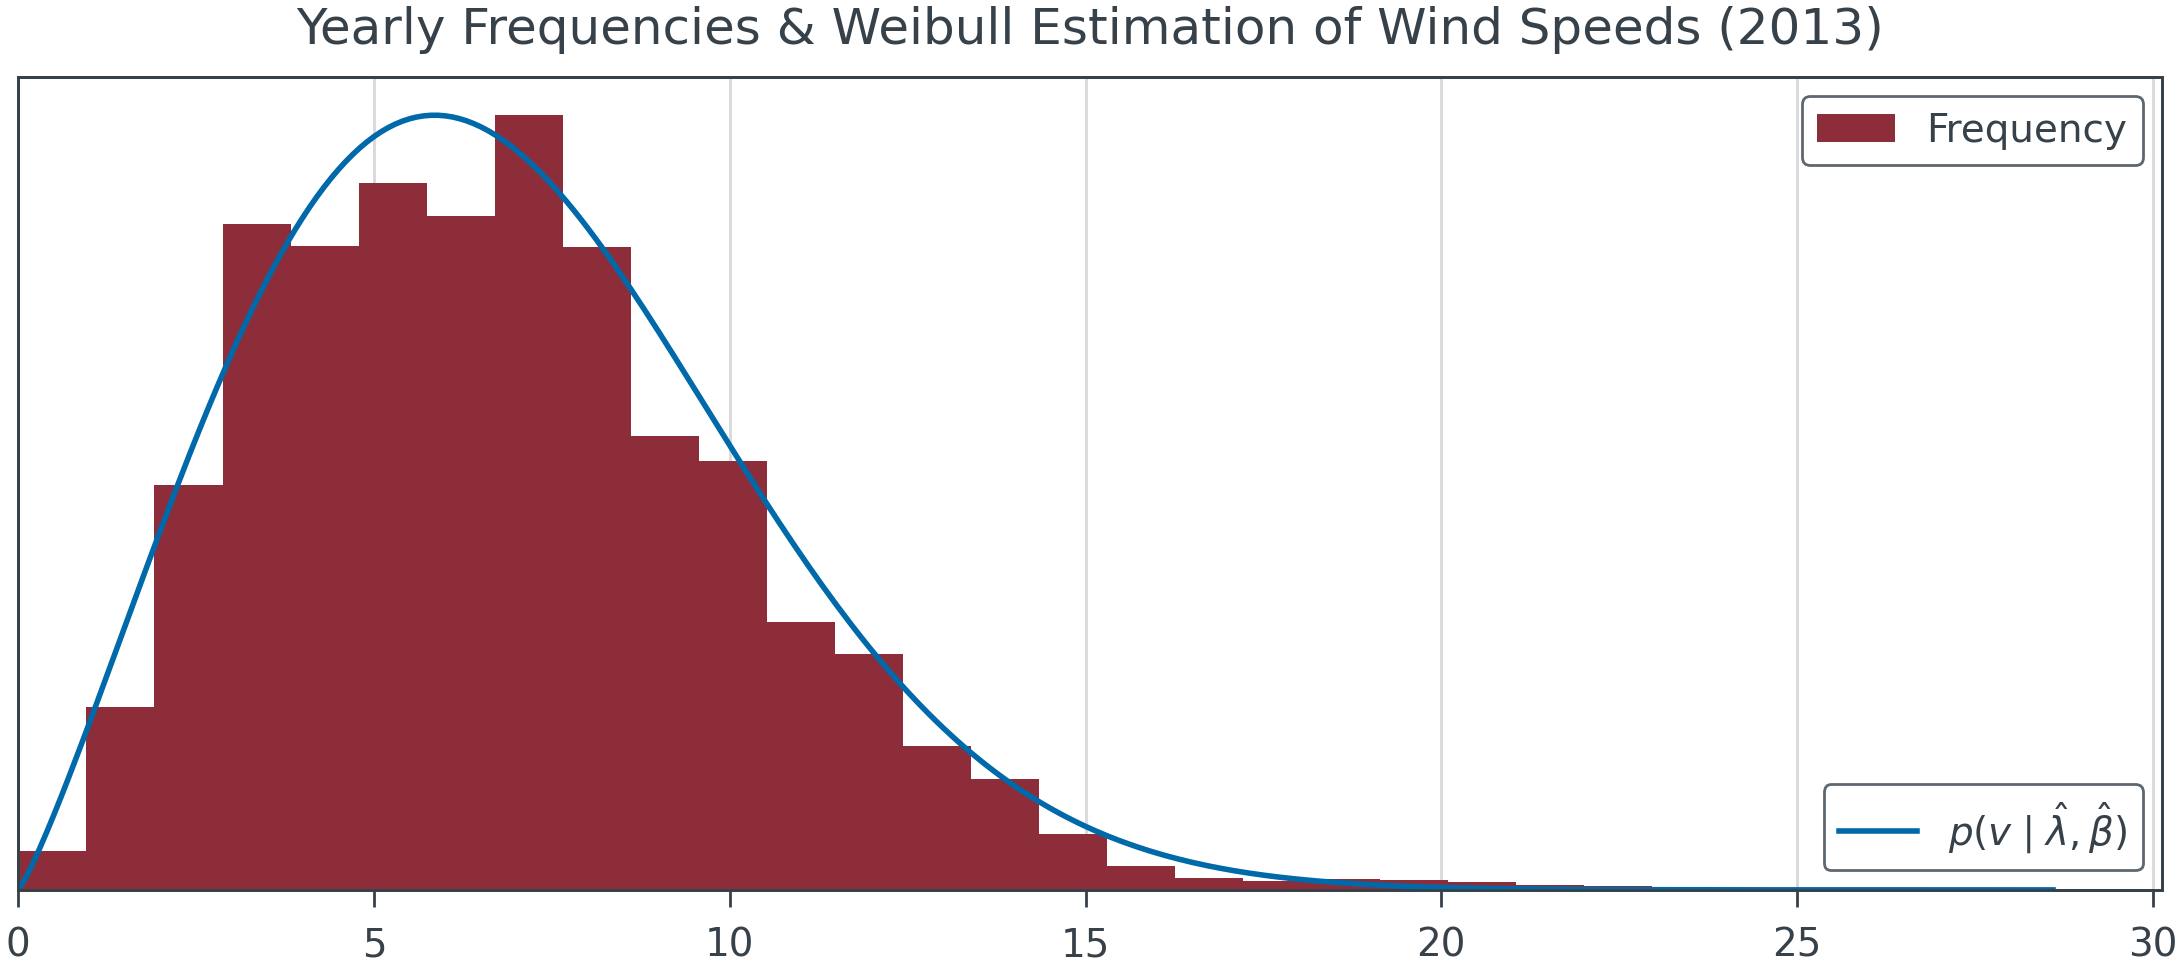

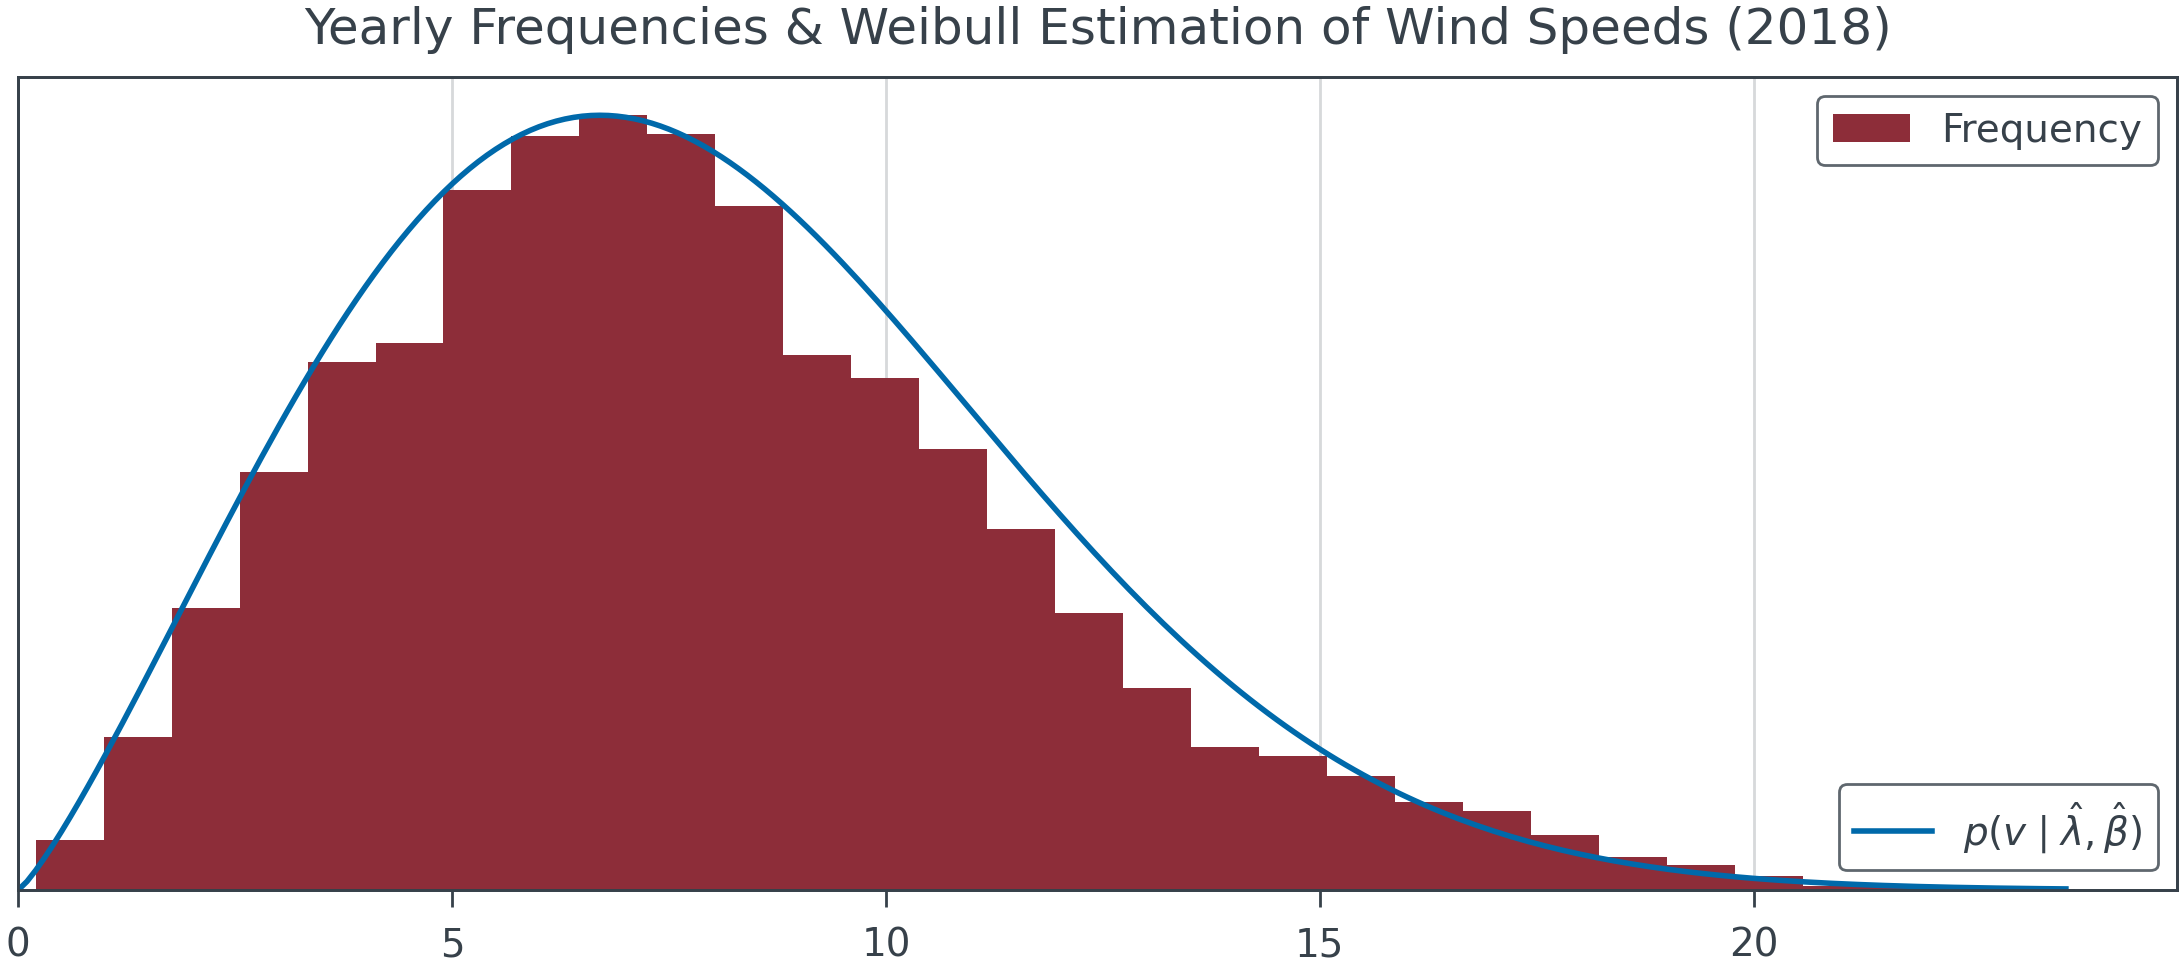

In [14]:
def plot_year(year, ax):
    year_df = wind_df[wind_df["MESS_DATUM"].dt.year == year]
    year_df_wind_mean = year_df["FF_10_wind"].mean()
    Y = year_df["FF_10_wind"].dropna().to_numpy()
    
    weibull = Weibull.estimate(Y)
    X = np.arange(0, np.max(Y), 0.1)

    ax1 = ax.twinx()
    ax1.plot(X, weibull.pdf(X), color=tp.constants.color.rgb.tue_blue, label=r"$p(v \mid \hat{\lambda}, \hat{\beta})$")
    ax1.set_ylim(0)
    ax1.set_yticklabels([])
    ax1.set_yticks([])
    ax1.legend(loc="lower right")


    year_df.hist(column="FF_10_wind", bins=30, ax=ax, color=tp.constants.color.rgb.tue_red, label="Frequency")
    ax.set_title("")
    ax.set_xlim(0)
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.legend(loc="upper right")
    ax.set_title(f"Yearly Frequencies & Weibull Estimation of Wind Speeds ({year})")

years = range(1998, 2023, 5)
for year in years:
    fig, ax = plt.subplots(1, 1)
    plot_year(year, ax)
plt.show()

Text(0, 0.5, '$p(v \\mid \\hat{\\lambda}, \\hat{\\beta})$')

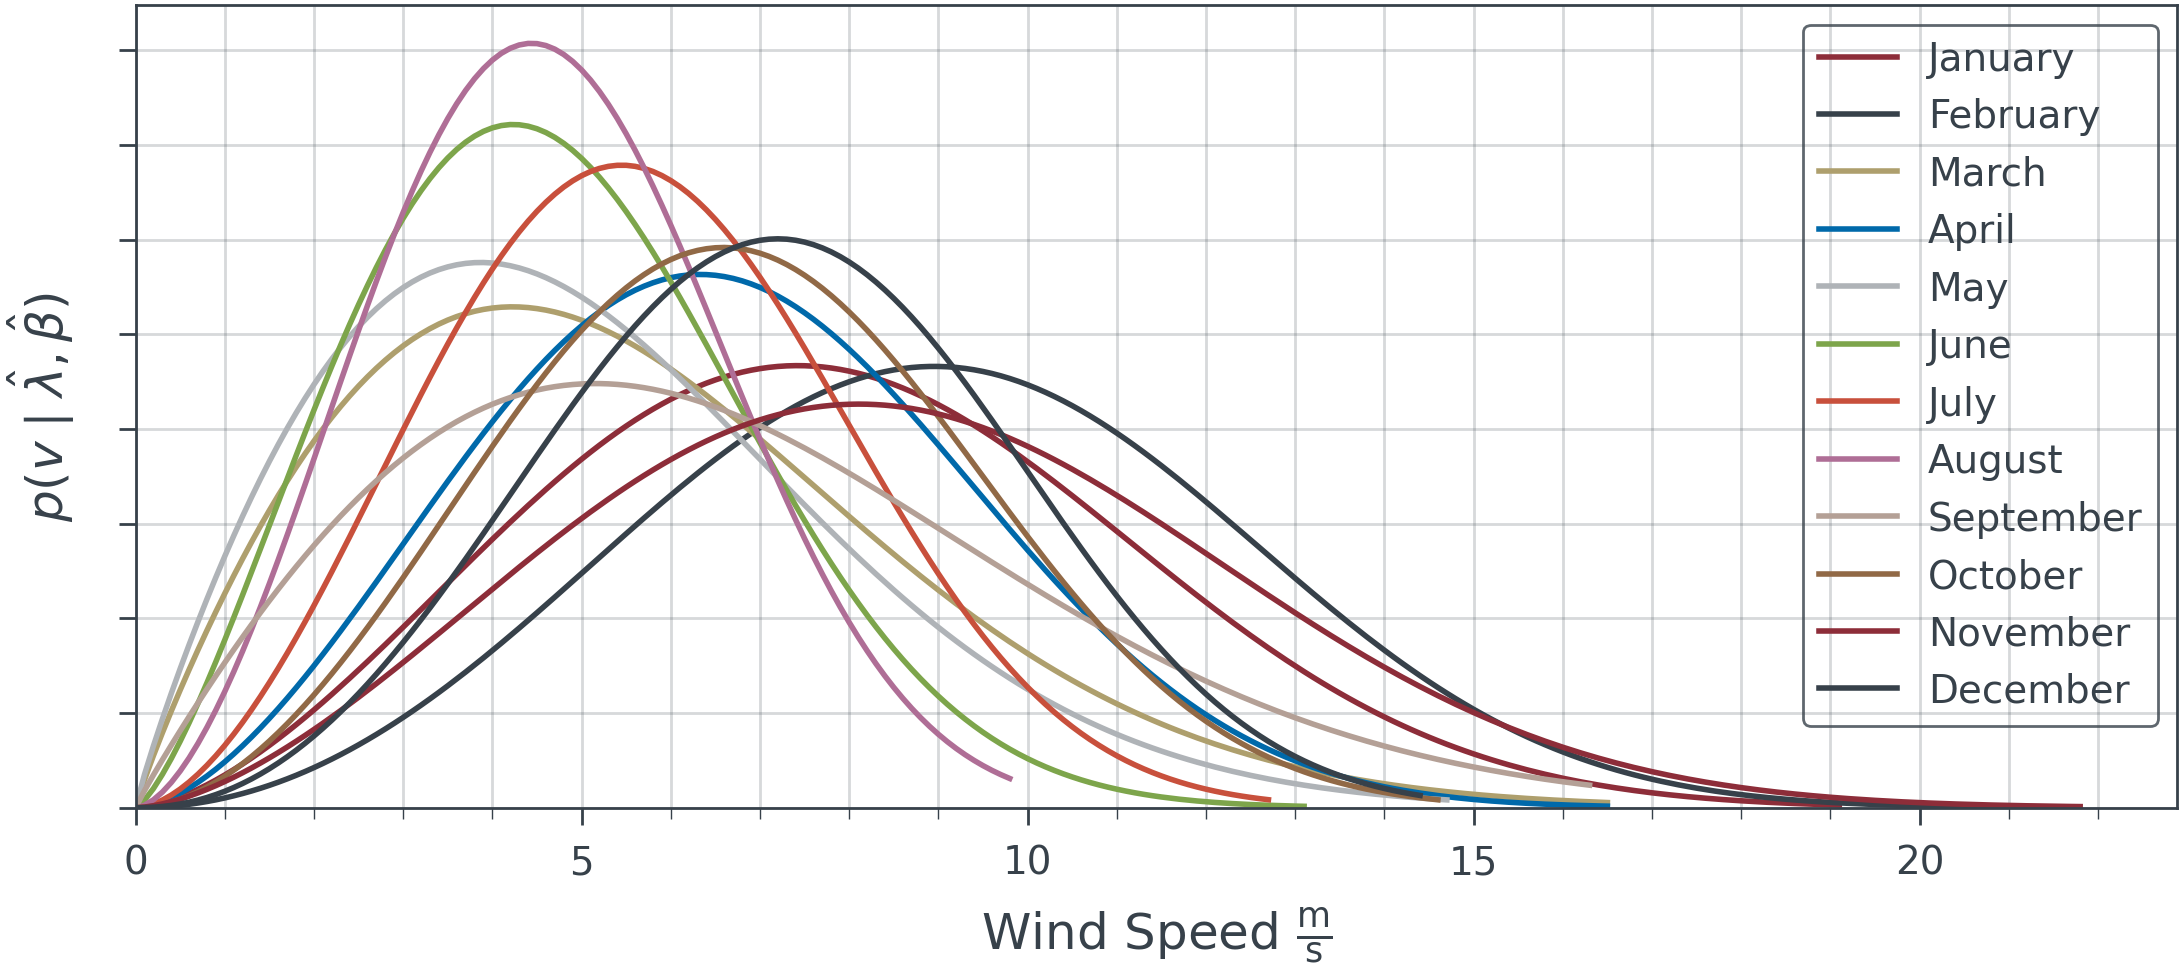

In [15]:
fig, ax = plt.subplots(1, 1)

for month, month_df in wind_df_2022.groupby("month"):
    Y = month_df["FF_10_wind"].dropna().to_numpy()
    X = np.arange(0, np.max(Y), 0.1)
    weibull = Weibull.estimate(Y)
    ax.plot(X, weibull.pdf(X), label=dt.datetime(2022, month, 1).strftime("%B"))
    # ax.axvline(weibull.mean, ls="-.", linewidth=0.25)
    
ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()
ax.set_xlabel(r"Wind Speed $\frac{\text{m}}{\text{s}}$")
ax.set_ylabel(r"$p(v \mid \hat{\lambda}, \hat{\beta})$")

Text(0, 0.5, '$p(v \\mid \\hat{\\lambda}, \\hat{\\beta})$')

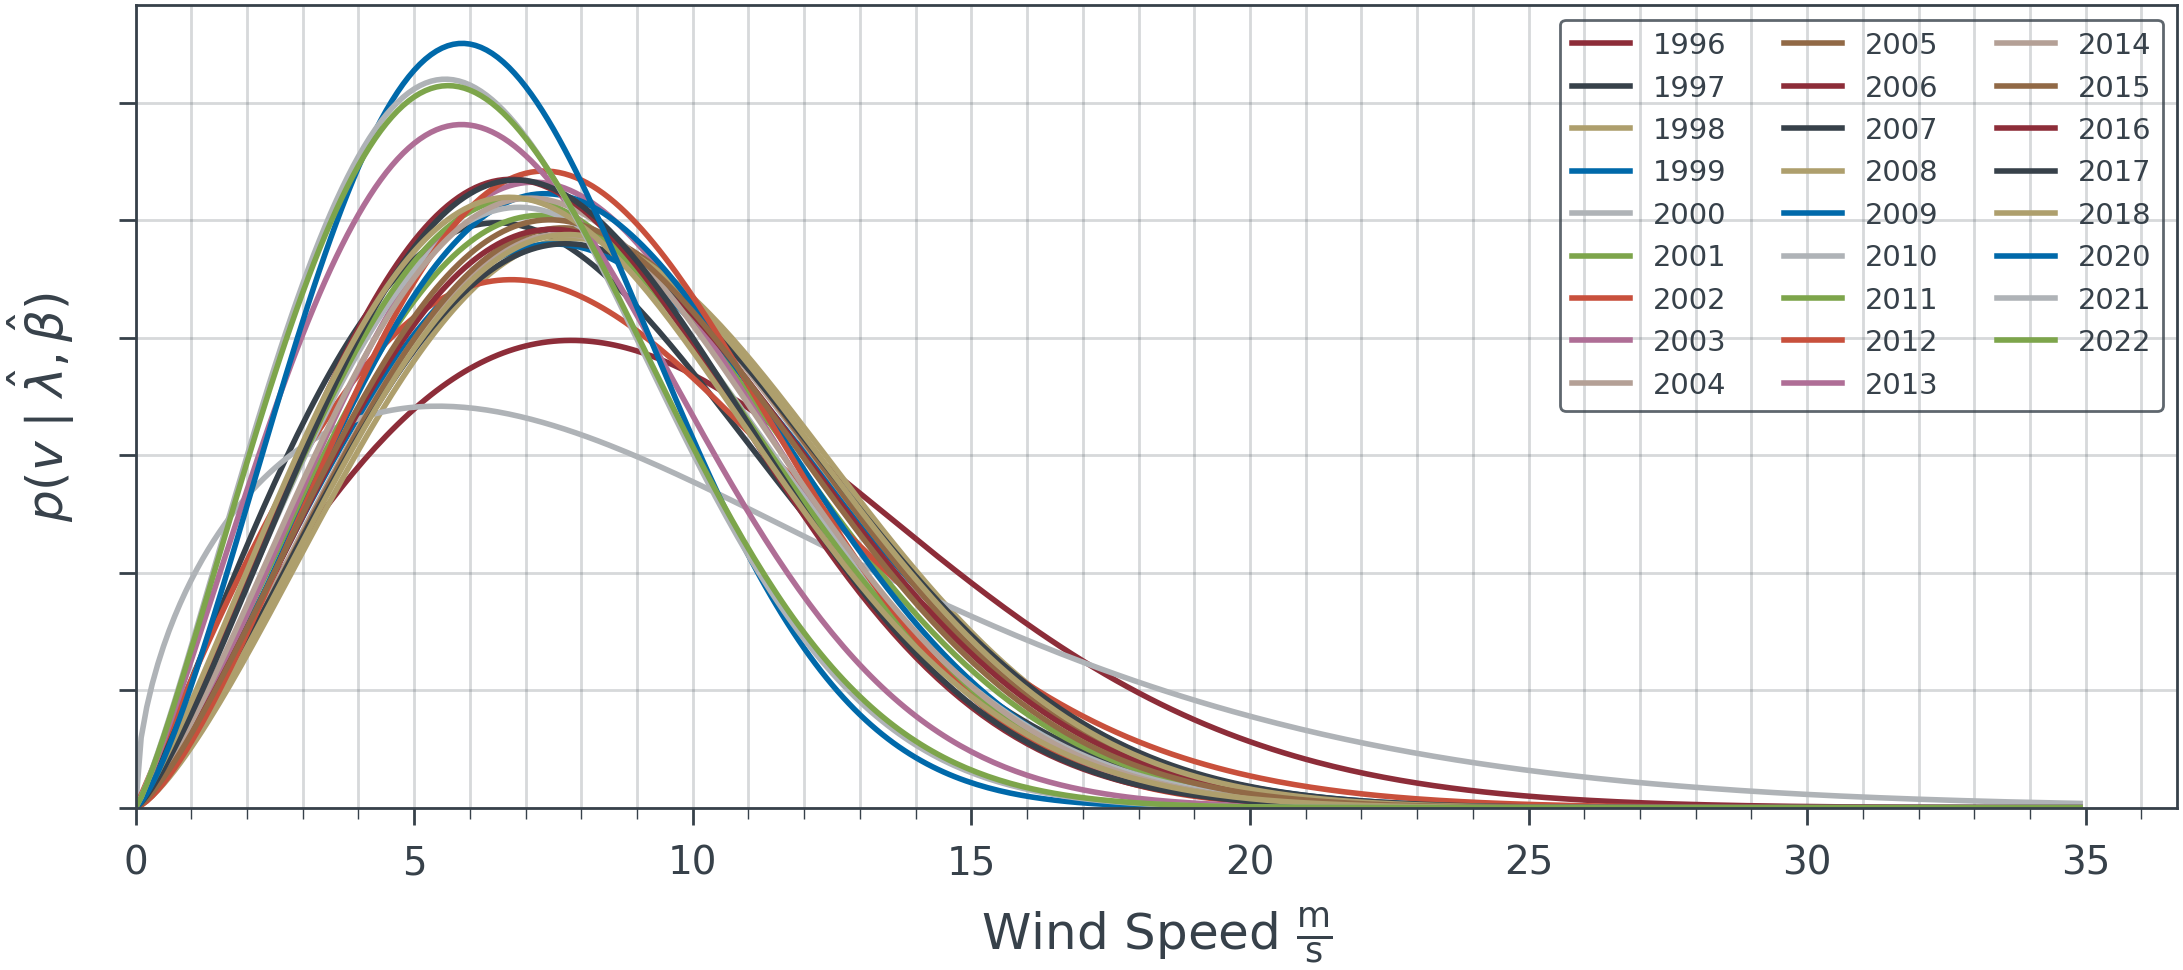

In [16]:
ig, ax = plt.subplots(1, 1)

for year, year_month_df in wind_df.groupby("year"):
    if year == 2019:
        continue
    Y = year_month_df["FF_10_wind"].dropna().to_numpy()
    X = np.arange(0, 35, 0.1)
    weibull = Weibull.estimate(Y)
    ax.plot(X, weibull.pdf(X), label=year)

ax.grid(which="both")
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1.0))
ax.set_yticklabels([])
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend(ncols=(2022 - 1996) / 8, fontsize="xx-small")
ax.set_xlabel(r"Wind Speed $\frac{\text{m}}{\text{s}}$")
ax.set_ylabel(r"$p(v \mid \hat{\lambda}, \hat{\beta})$")

In [17]:
wind_month_pdfs = []
for (year, month), year_month_df in wind_df.groupby(["year", "month"]):
    # no data here
    if year == 2019 or year == 2018 and month == 12 or year == 2000:
        continue
    X = year_month_df["FF_10_wind"].dropna().copy()
    pdf = Weibull.estimate(X)
    wind_month_pdfs.append([year, month, pdf, X])
wind_month_pdfs = pd.DataFrame(wind_month_pdfs, columns=["year", "month", "pdf", "wind"])
wind_month_pdfs
        

year  month                                       pdf  \
0    1996     12  <__main__.Weibull object at 0x178df6830>   
1    1997      1  <__main__.Weibull object at 0x16d8cf430>   
2    1997      2  <__main__.Weibull object at 0x178dcd0f0>   
3    1997      3  <__main__.Weibull object at 0x16dd85cc0>   
4    1997      4  <__main__.Weibull object at 0x178dae320>   
..    ...    ...                                       ...   
282  2022      8  <__main__.Weibull object at 0x17876ef20>   
283  2022      9  <__main__.Weibull object at 0x17876e770>   
284  2022     10  <__main__.Weibull object at 0x17876e4a0>   
285  2022     11  <__main__.Weibull object at 0x17876c0a0>   
286  2022     12  <__main__.Weibull object at 0x178740a30>   

                                                  wind  
0    0       15.8
1       16.2
2       16.6
3      ...  
1    1559    7.9
1560    8.7
1561    8.8
1562    8....  
2    5428    3.2
5429    3.1
5430    3.0
5431    2....  
3    8922     8.2
8923     8.5
8924     8.3
8925   ...  
4    12772    7.2
12773    6.8
12774    6.8
12775  ...  
..                                                 ...  
282  132715    6.2
132716    6.4
132717    6.1
1327...  
283  137179     7.7
137180     7.2
137181     7.2
1...  
284  141499    12.2
141500    12.8
141501    11.7
1...  
285  145963    10.3
145964    10.2
145965     9.7
1...  
286  150283     5.6
150284     5.7
150285     5.6
1...  

[287 rows x 4 columns]

Text(0.5, 0.98, 'Expected Energy Density for each month')

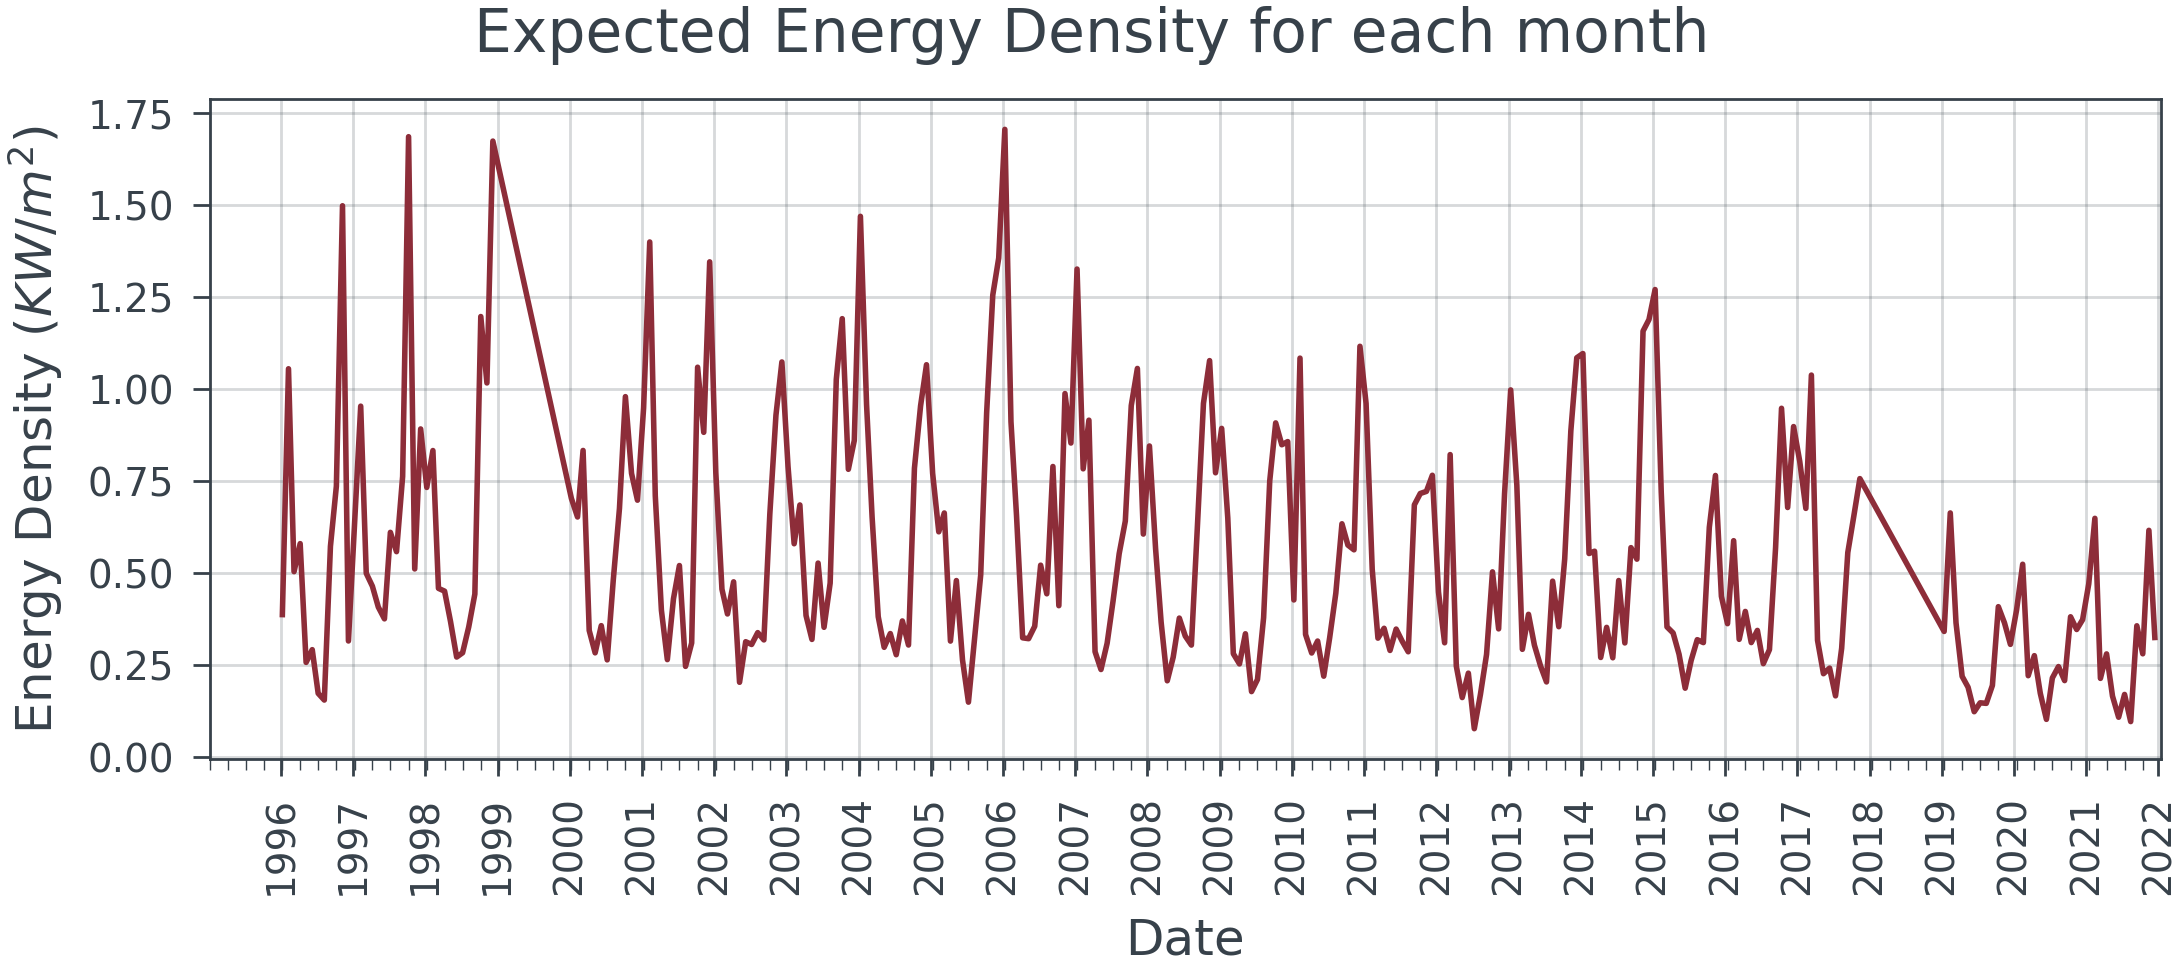

In [64]:
# https://en.wikipedia.org/wiki/Density_of_air#Dry_air
air_rho = 1.2250
# 120 meter diameter of wind turbine
sweep_area = math.pi * (70 / 2) ** 2
def energy_density(v, A=sweep_area, rho=air_rho):
    # kg/m^3 * m^2 * m^3 / s^3 = kg * m^2/s^3 = W (Watt)
    return 1 / 2 * rho * A * v ** 3

def expected_density(p: Weibull, A=sweep_area, rho=air_rho):
    return 1/2 * rho * p.lambd ** 3 * scipy.special.gamma(1 + 3 / p.beta)

# plot expected values for each month
fig, ax = plt.subplots(1, 1)
vals = []
for (year, month), year_month_df in wind_month_pdfs.groupby(["year", "month"]):
    if year < 1997: continue
    vals.append((year, month, 1e-3 * expected_density(year_month_df.pdf.values[0])))
    # vals.append((year, month, year_month_df.pdf.values[0].mean))
months = list(map(lambda t: dt.datetime(t[0], t[1], 1), vals))
e = list(map(lambda t: t[2], vals))
ax.plot(months, e)
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(365))
ax.xaxis.set_major_formatter(mdt.DateFormatter("%Y"))
ax.xaxis.set_minor_locator(mdt.MonthLocator(interval=3))
# ax.xaxis.set_minor_formatter(mdt.DateFormatter("%b"))
ax.tick_params(axis='x', which='minor', rotation=45, labelsize=3)
ax.tick_params(axis='x', which="major", rotation=90)
ax.set_xlabel("Date")
ax.set_xlim((dt.datetime(1996, 1, 1), dt.datetime(2022, 12, 30)))
ax.set_ylabel("Energy Density ($KW/m^2$)")
ax.grid()
fig.suptitle("Expected Energy Density for each month")

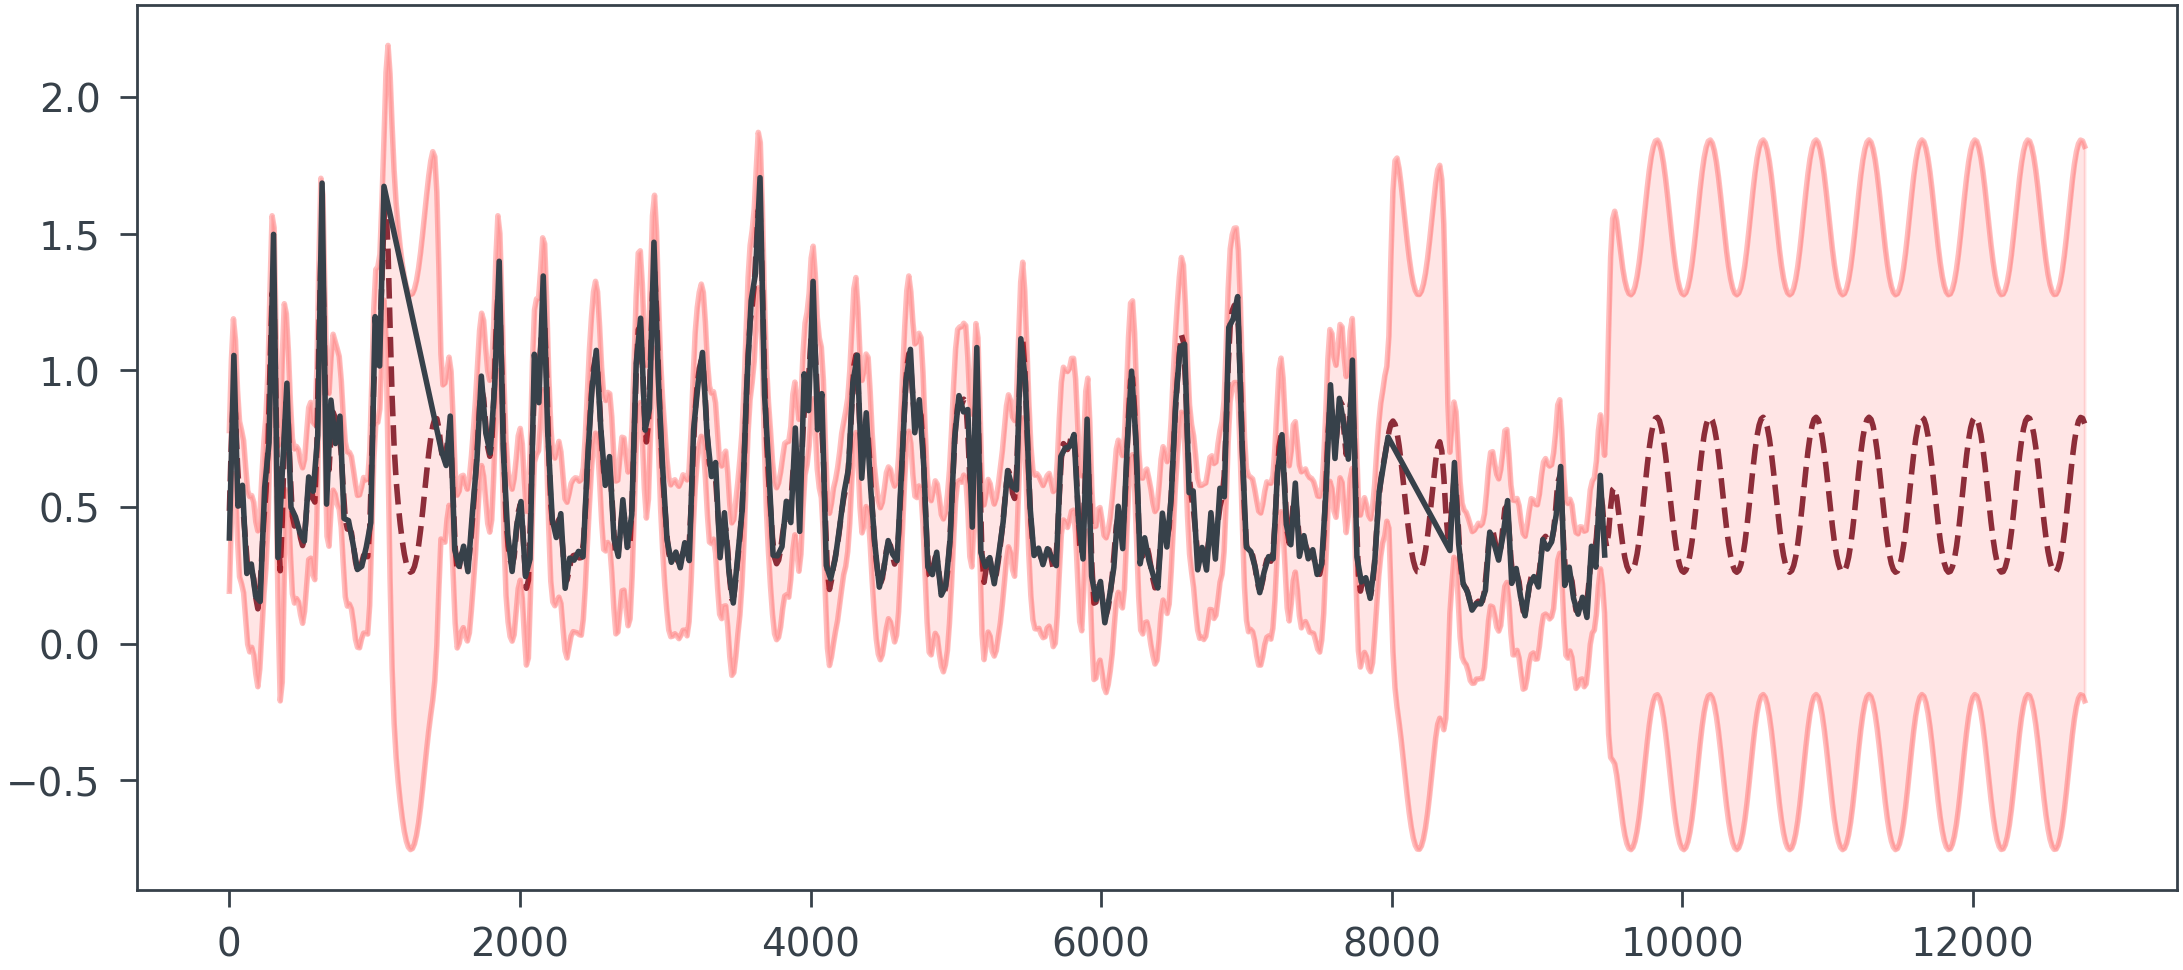

In [204]:
from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as GPK

Y = np.array(e)
start = dt.datetime(1997, 1, 1)
X = np.array(list(map(lambda d: (d - start).days, months))).reshape(-1, 1)

k = GPK.ExpSineSquared(length_scale=2, periodicity=365) + GPK.RBF(length_scale=30)# + X.mean()
gp = GP(kernel=k, optimizer=None, alpha=1e-1)
gp.fit(X, Y)

r = range(0, 365 * (2022 - 1997) + 365 * 10, 14)
x = np.array(r).reshape(-1, 1)
pred, std = gp.predict(x, return_std=True)
plt.plot(x, pred, "--")
plt.plot(x, pred + std, "-", alpha=0.25, color="red")
plt.plot(x, pred - std, "-", alpha=0.25, color="red")
plt.fill_between(x.reshape(-1), pred + std, pred - std, color="red", alpha=0.1)
plt.plot(X, Y)